20:25:17 - cmdstanpy - INFO - Chain [1] start processing
20:25:17 - cmdstanpy - INFO - Chain [1] done processing
20:25:17 - cmdstanpy - INFO - Chain [1] start processing
20:25:17 - cmdstanpy - INFO - Chain [1] done processing
20:25:18 - cmdstanpy - INFO - Chain [1] start processing
20:25:18 - cmdstanpy - INFO - Chain [1] done processing
20:25:18 - cmdstanpy - INFO - Chain [1] start processing
20:25:18 - cmdstanpy - INFO - Chain [1] done processing
20:25:19 - cmdstanpy - INFO - Chain [1] start processing
20:25:19 - cmdstanpy - INFO - Chain [1] done processing
20:25:19 - cmdstanpy - INFO - Chain [1] start processing
20:25:19 - cmdstanpy - INFO - Chain [1] done processing
20:25:19 - cmdstanpy - INFO - Chain [1] start processing
20:25:19 - cmdstanpy - INFO - Chain [1] done processing
20:25:20 - cmdstanpy - INFO - Chain [1] start processing
20:25:20 - cmdstanpy - INFO - Chain [1] done processing
20:25:20 - cmdstanpy - INFO - Chain [1] start processing
20:25:20 - cmdstanpy - INFO - Chain [1]

Pizza bbq_ckn_l: MAPE = 0.38
Pizza bbq_ckn_m: MAPE = 0.51
Pizza bbq_ckn_s: MAPE = 0.45
Pizza big_meat_s: MAPE = 0.25
Pizza brie_carre_s: MAPE = 0.44
Pizza calabrese_m: MAPE = 0.54
Pizza calabrese_s: MAPE = 0.69
Pizza cali_ckn_l: MAPE = 0.36
Pizza cali_ckn_m: MAPE = 0.50
Pizza cali_ckn_s: MAPE = 0.48
Pizza ckn_alfredo_l: MAPE = 0.82
Pizza ckn_alfredo_m: MAPE = 0.33
Pizza ckn_alfredo_s: MAPE = 0.38
Pizza ckn_pesto_l: MAPE = 0.88
Pizza ckn_pesto_m: MAPE = 0.85
Pizza ckn_pesto_s: MAPE = 0.46
Pizza classic_dlx_l: MAPE = 0.33
Pizza classic_dlx_m: MAPE = 0.32
Pizza classic_dlx_s: MAPE = 0.32
Pizza five_cheese_l: MAPE = 0.26
Pizza four_cheese_l: MAPE = 0.20
Pizza four_cheese_m: MAPE = 0.37
Pizza green_garden_l: MAPE = 0.87
Pizza green_garden_m: MAPE = 0.75
Pizza green_garden_s: MAPE = 0.39
Pizza hawaiian_l: MAPE = 0.40
Pizza hawaiian_m: MAPE = 0.80
Pizza hawaiian_s: MAPE = 0.27
Pizza ital_cpcllo_l: MAPE = 0.74
Pizza ital_cpcllo_m: MAPE = 0.21
Pizza ital_cpcllo_s: MAPE = 0.42
Pizza ital_supr_l:

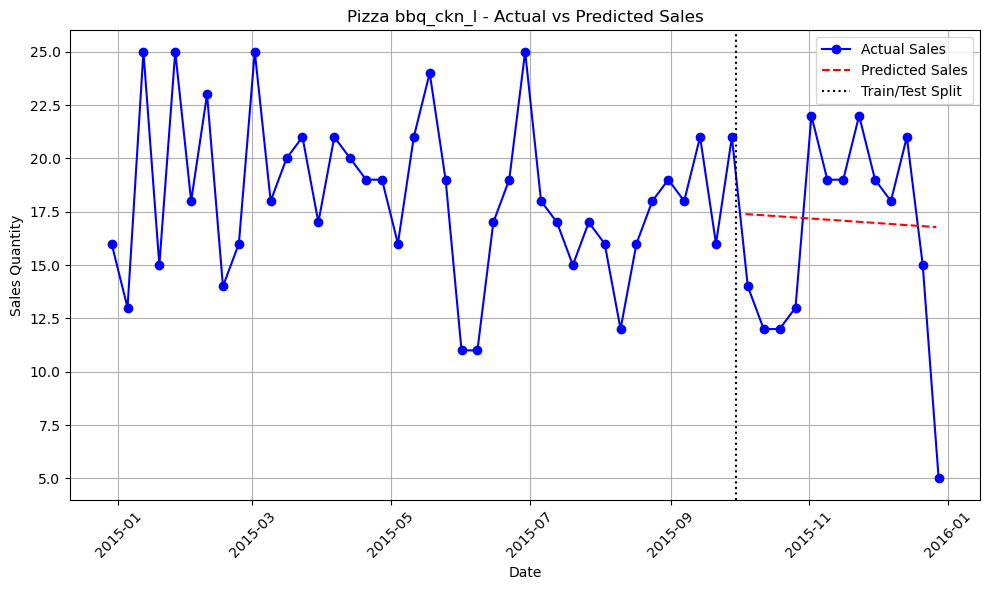

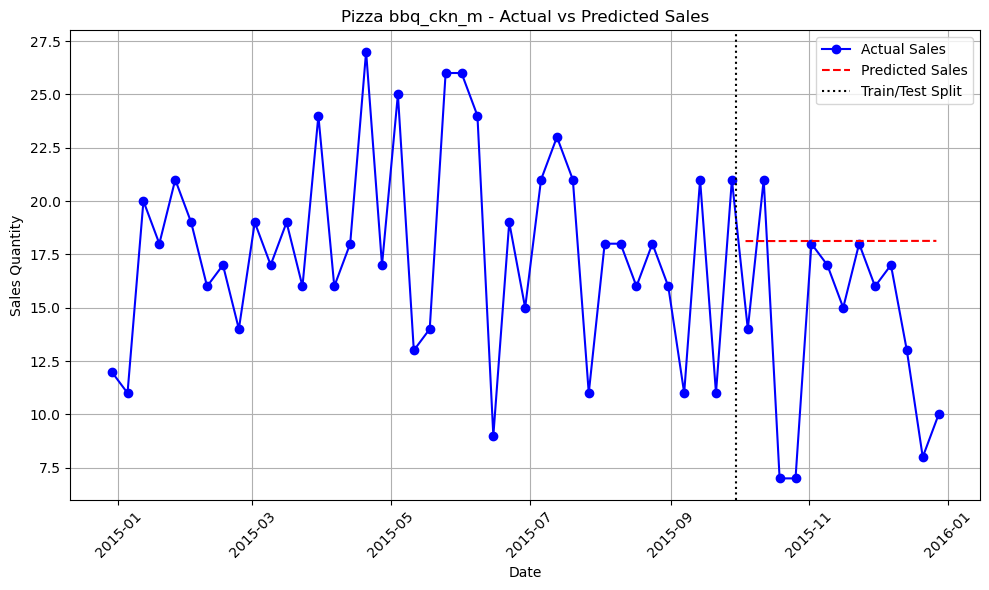

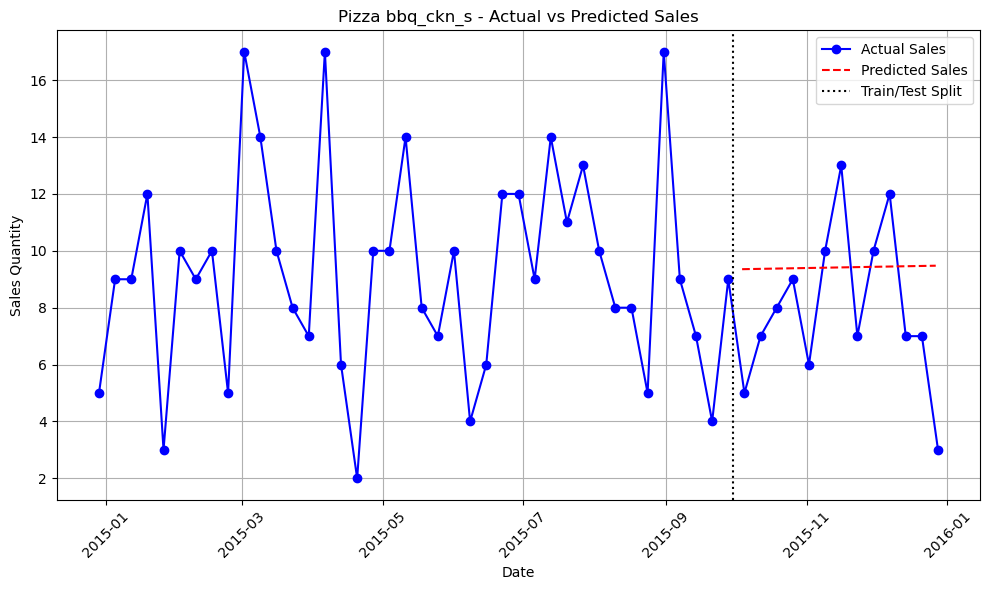

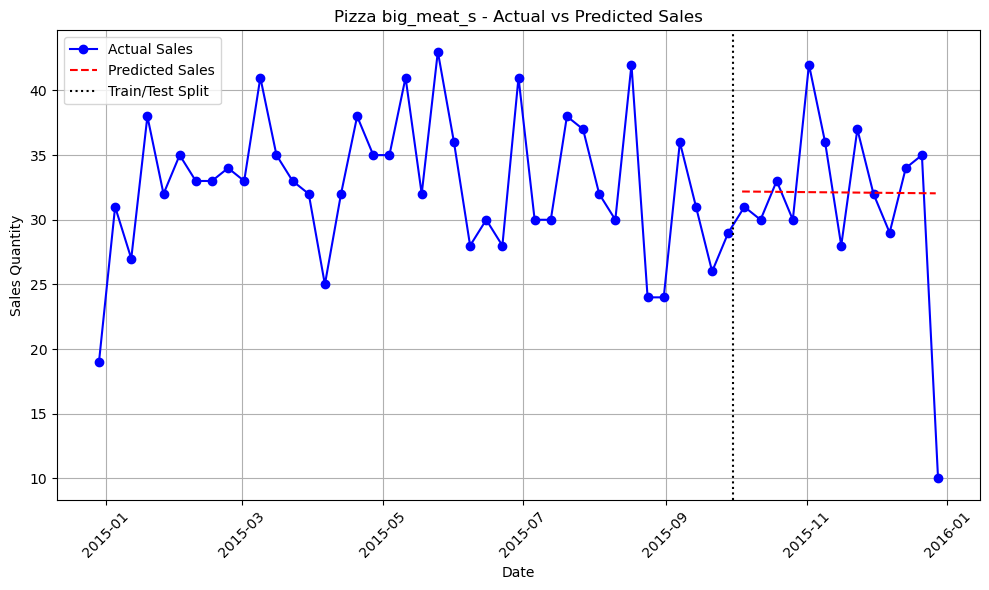

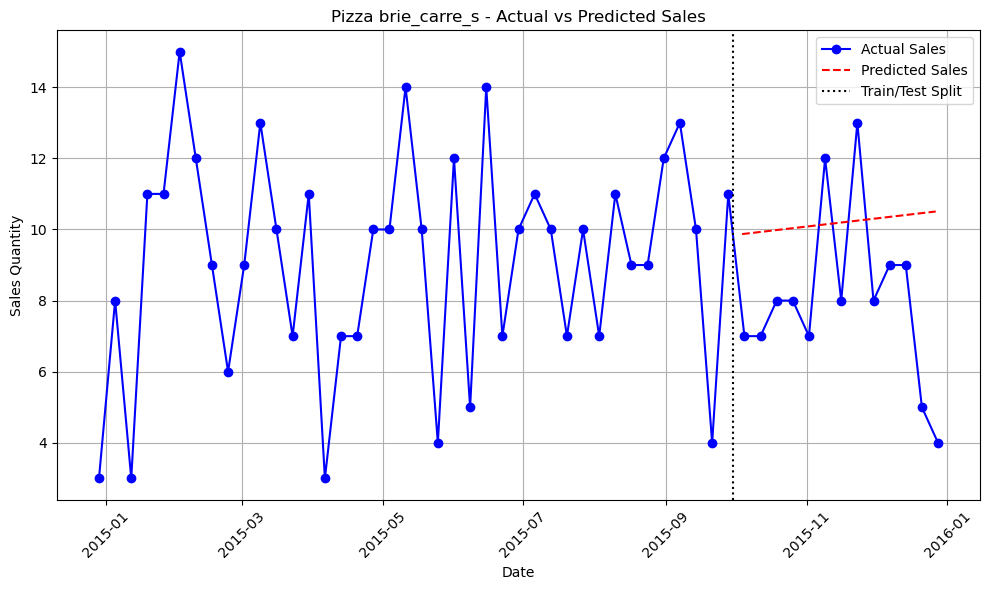

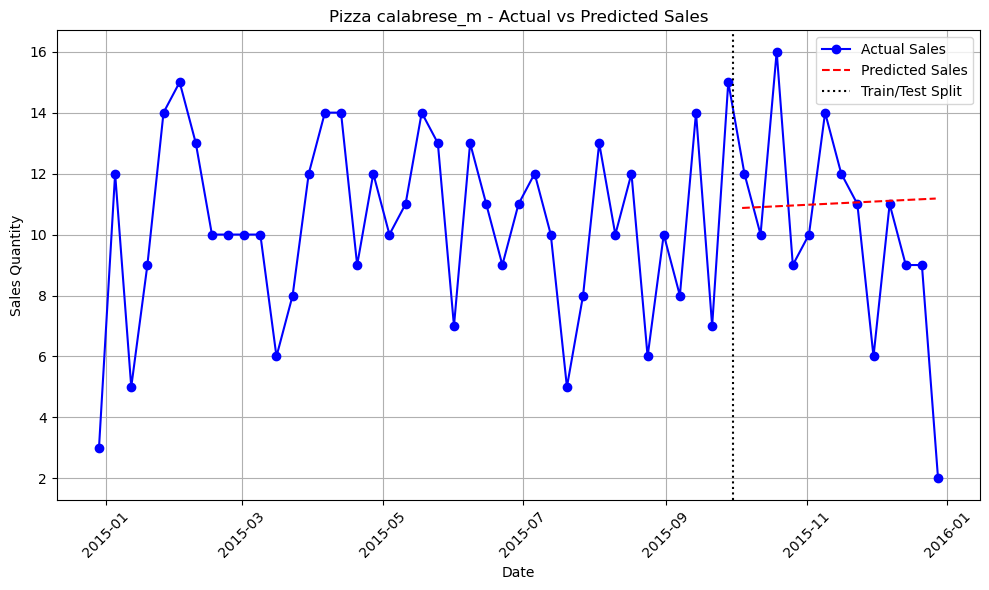

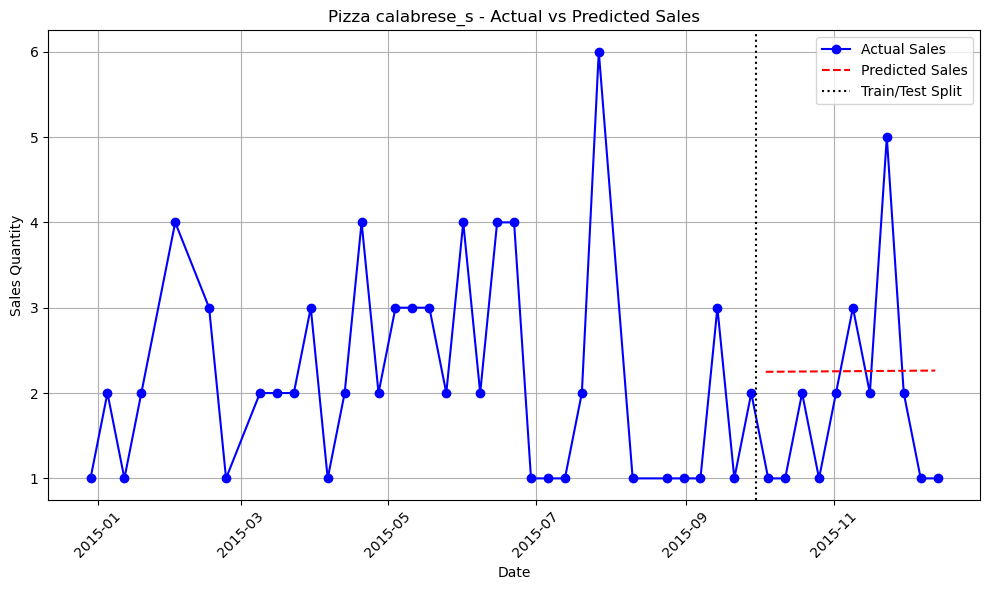

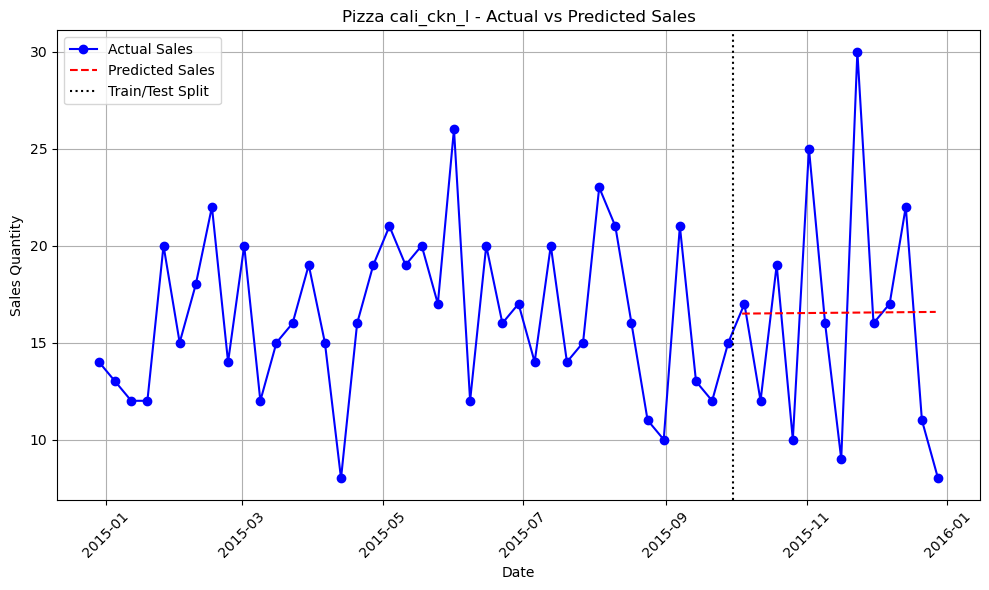

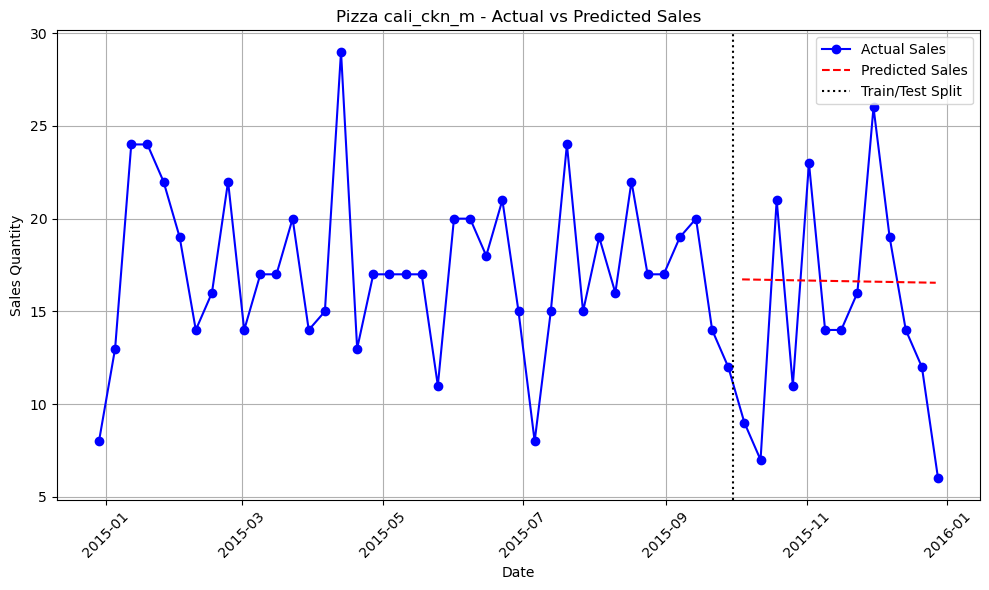

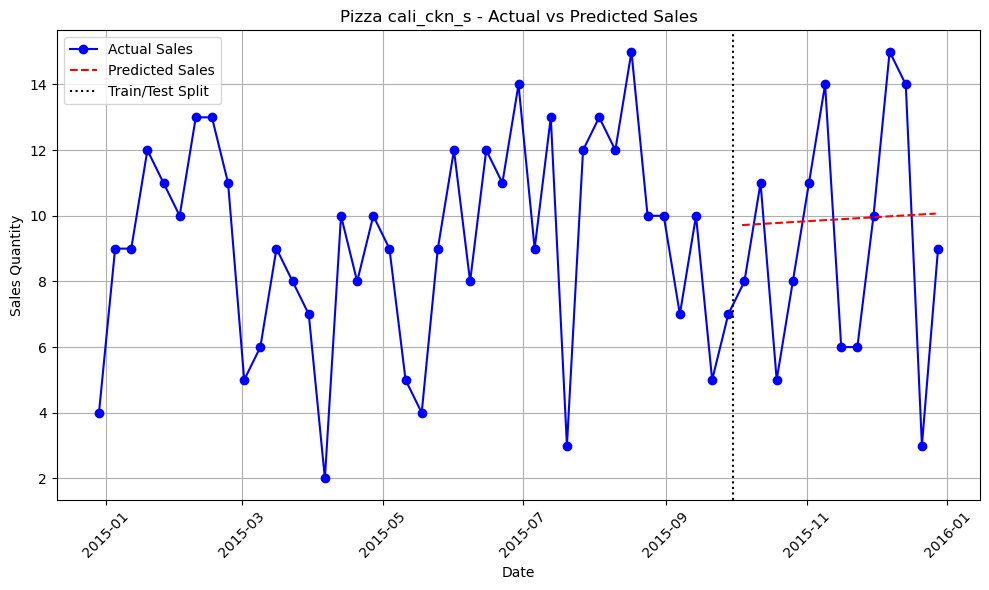

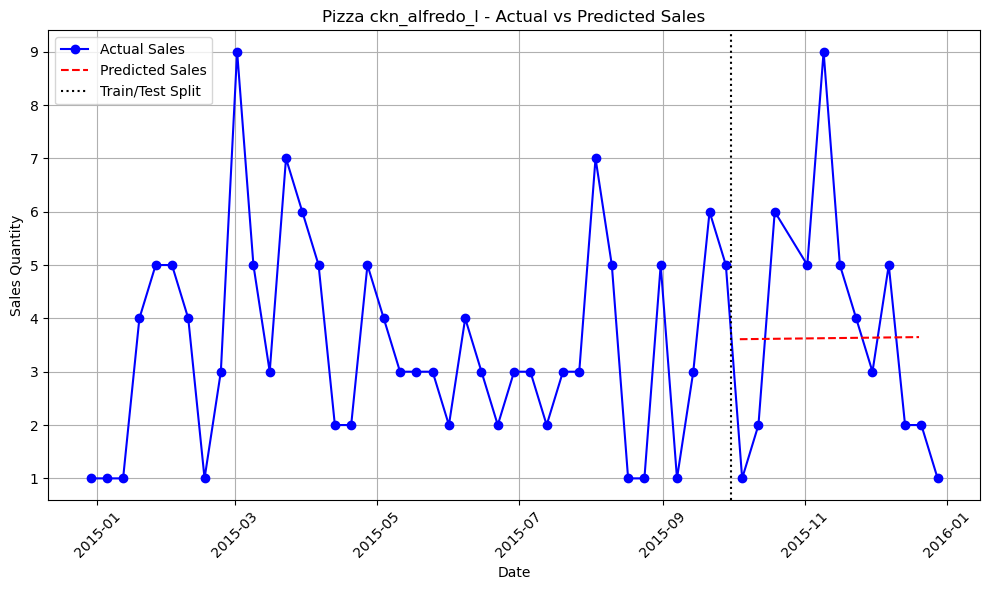

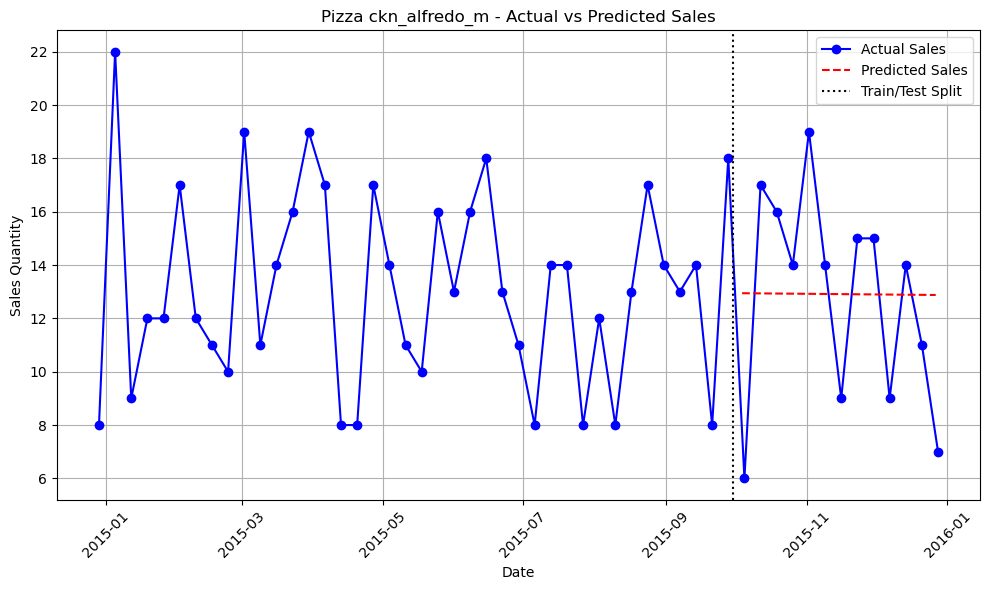

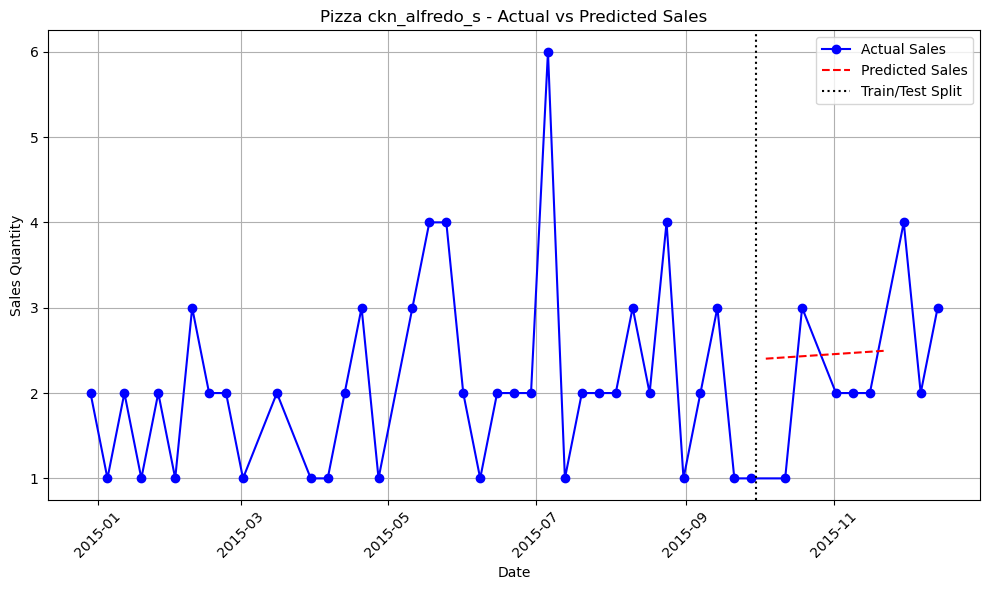

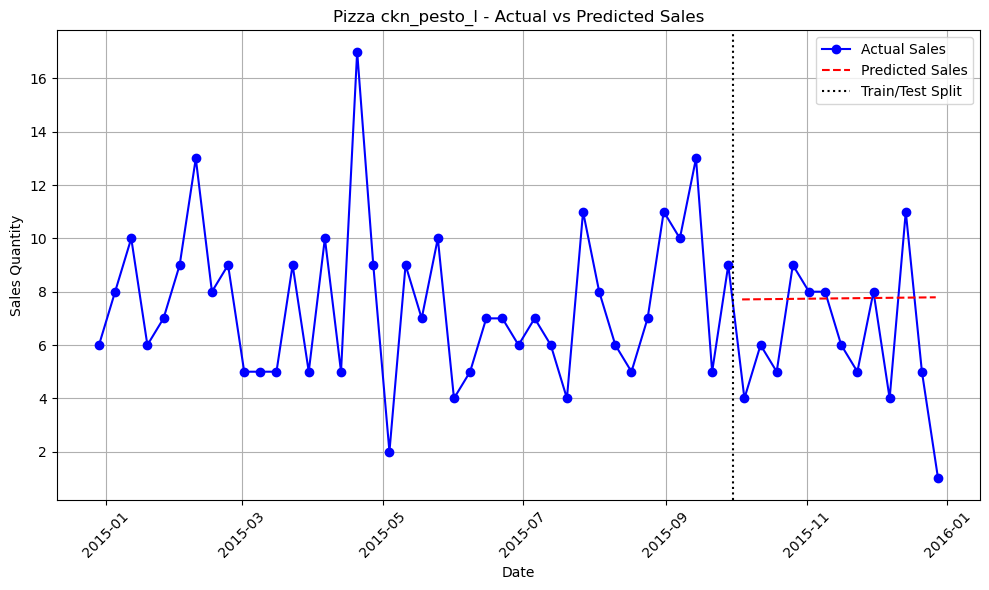

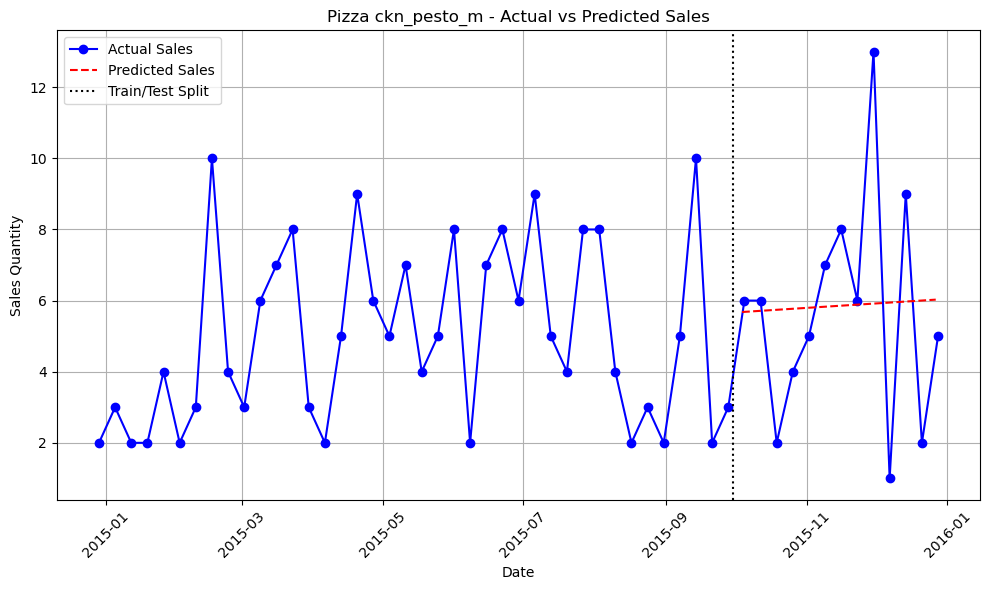

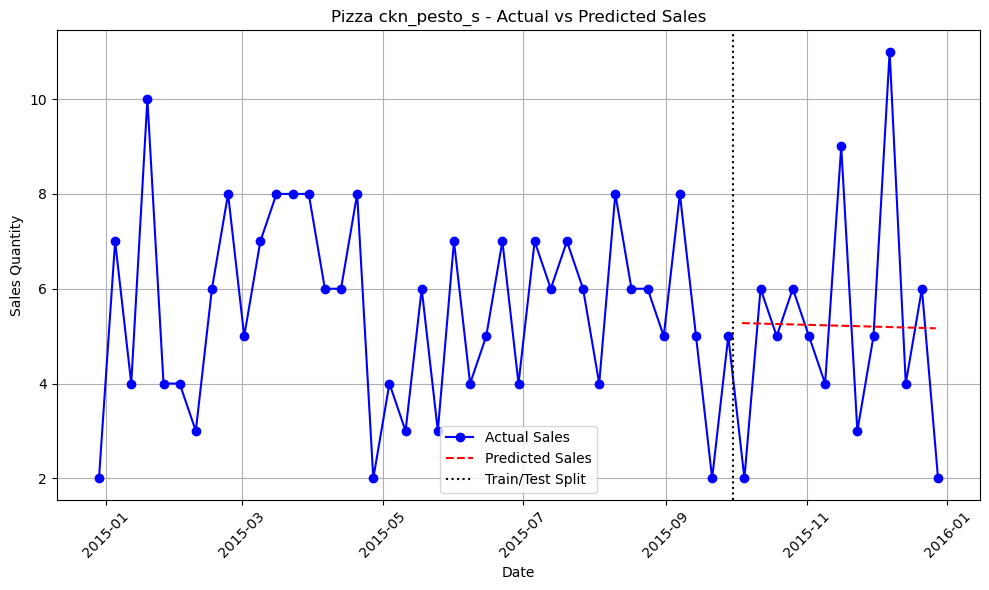

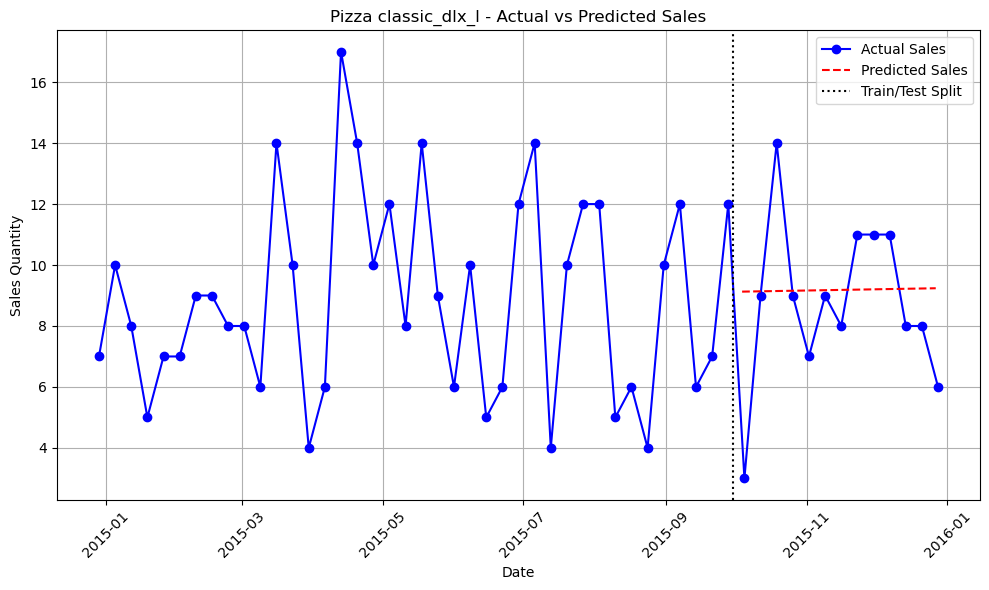

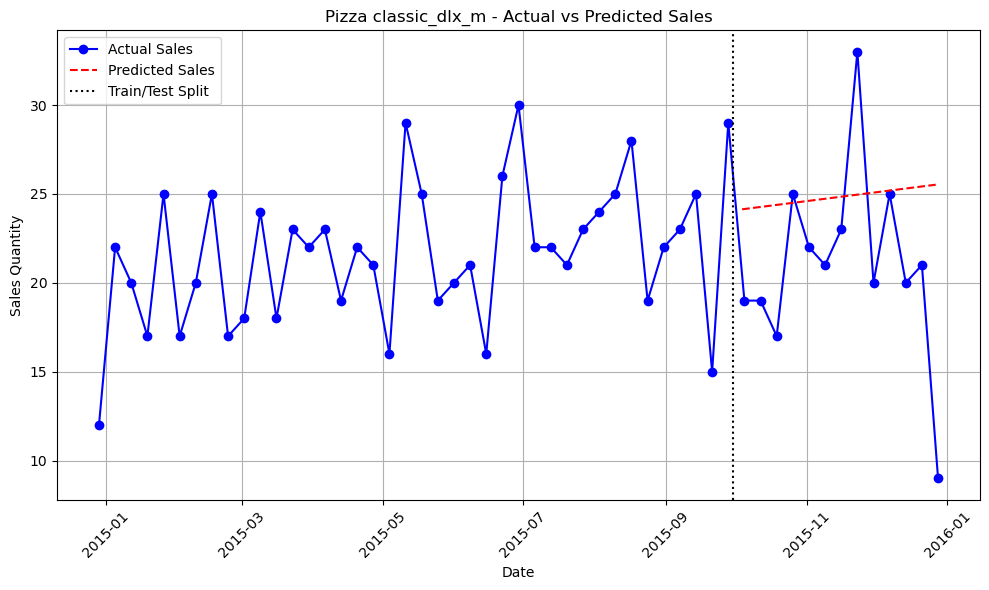

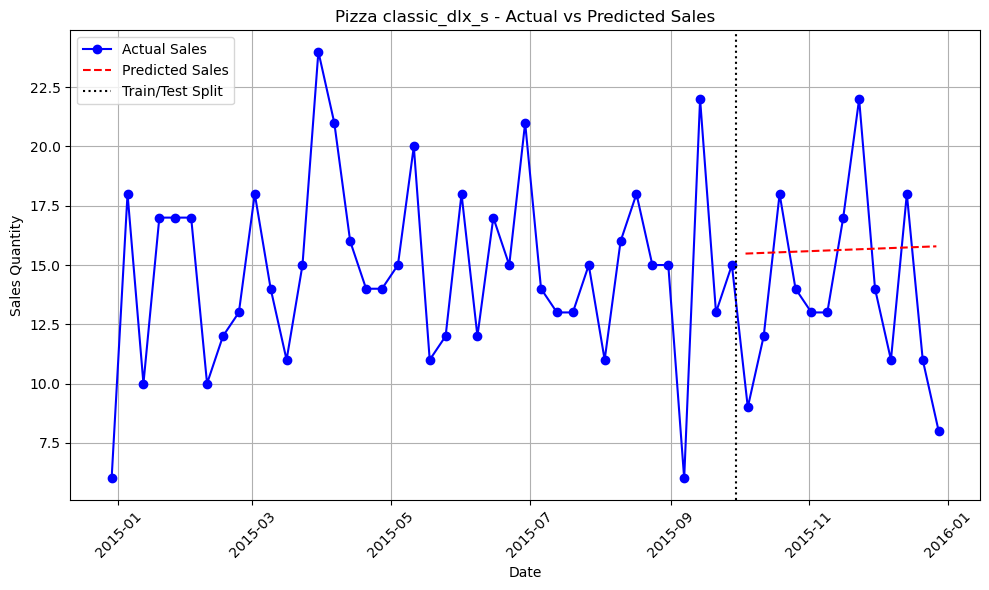

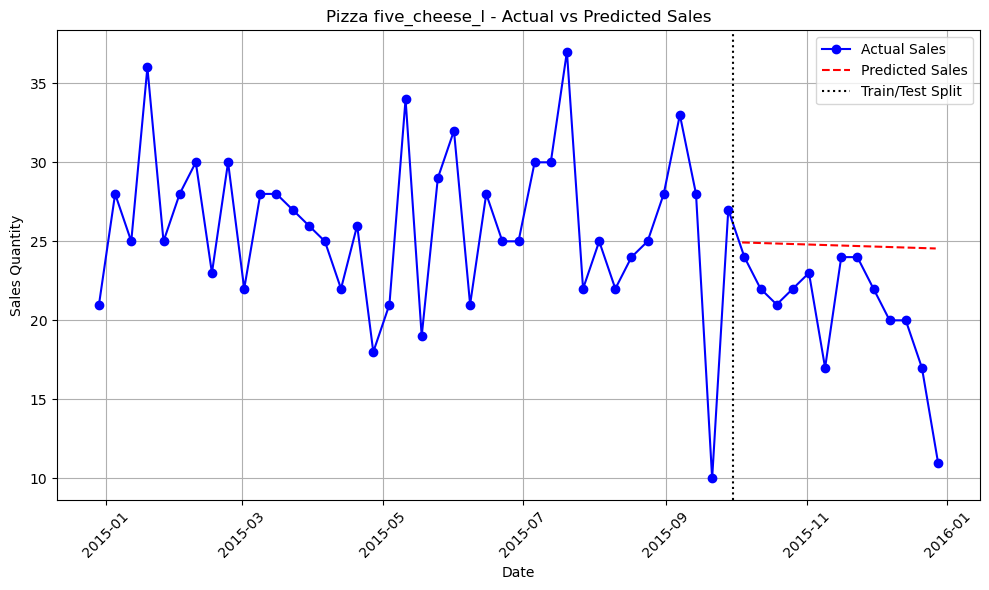

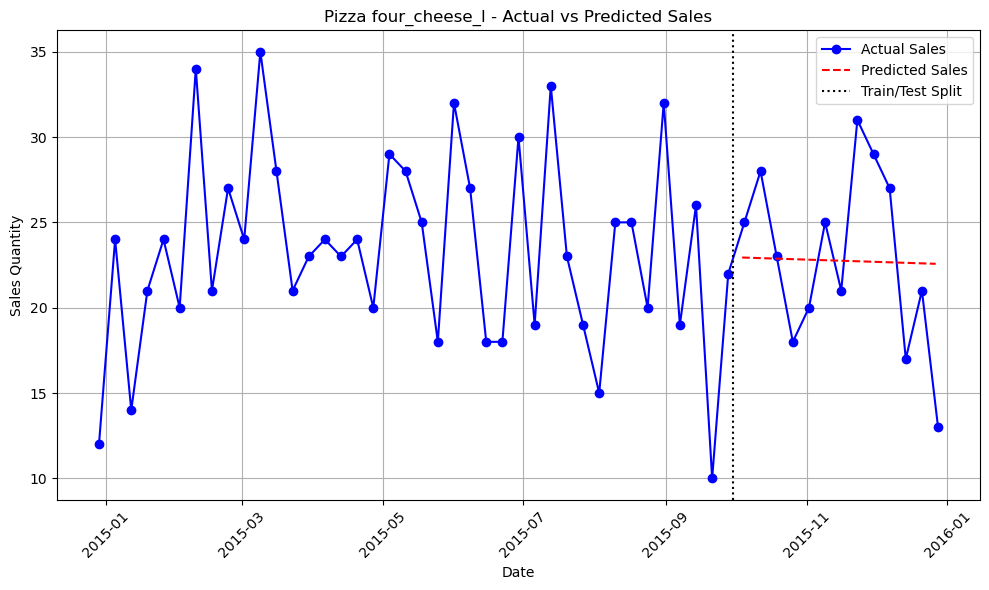

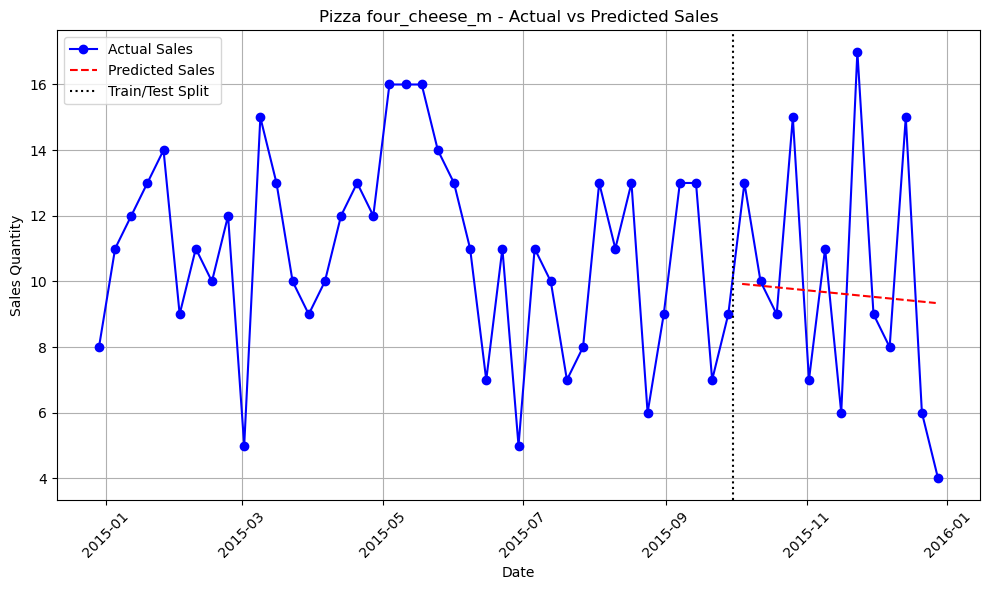

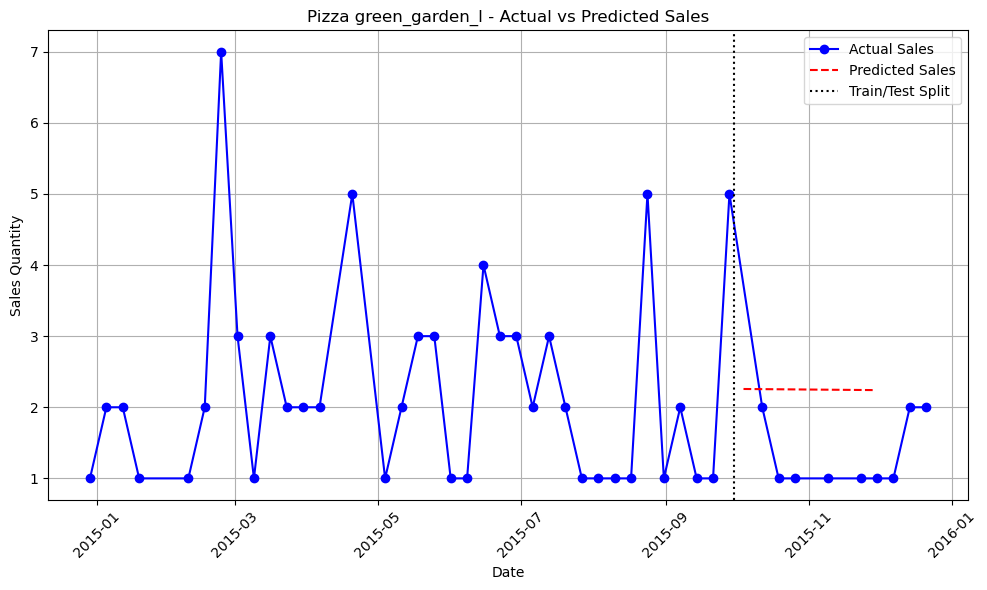

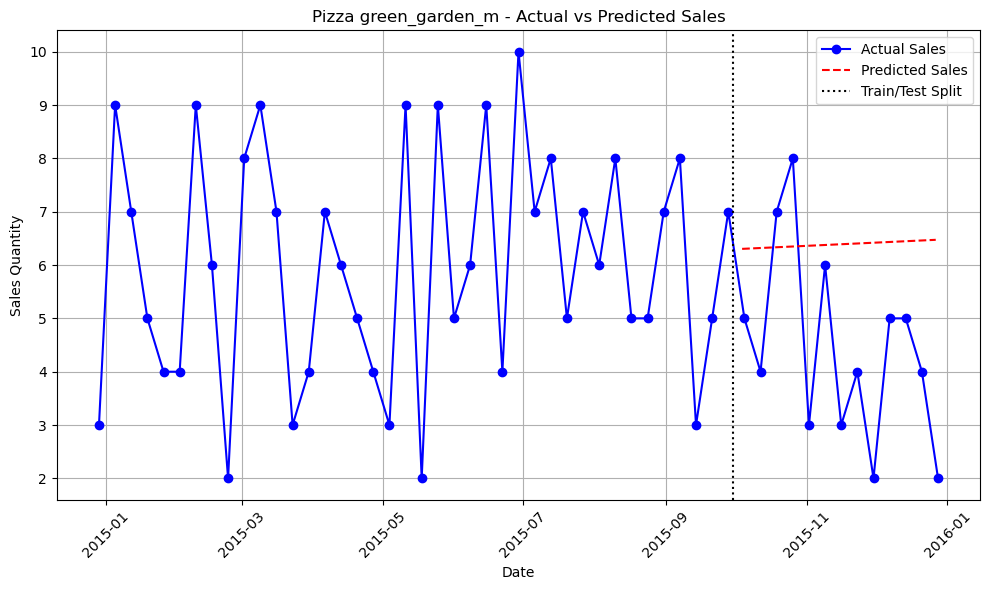

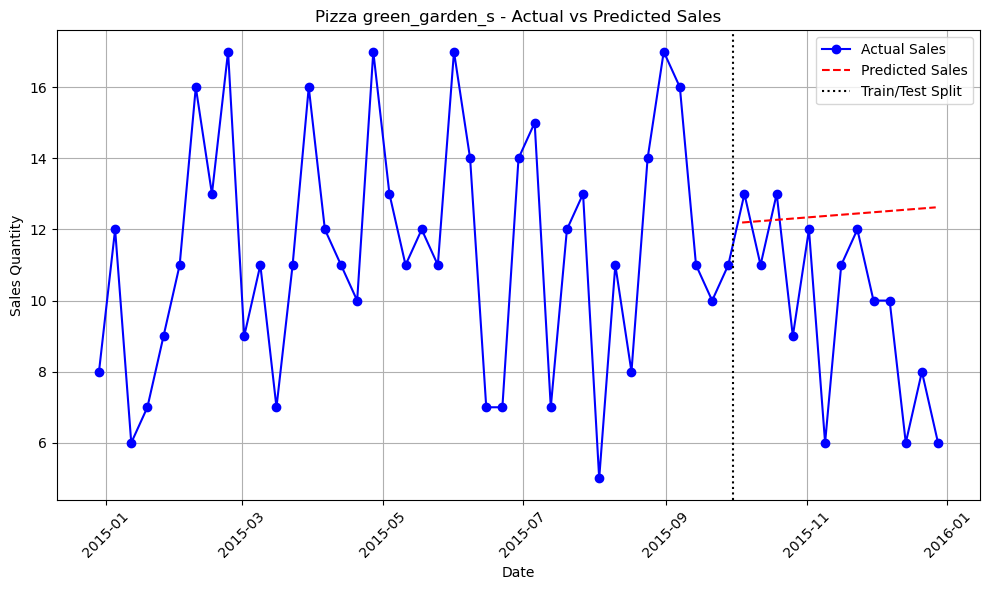

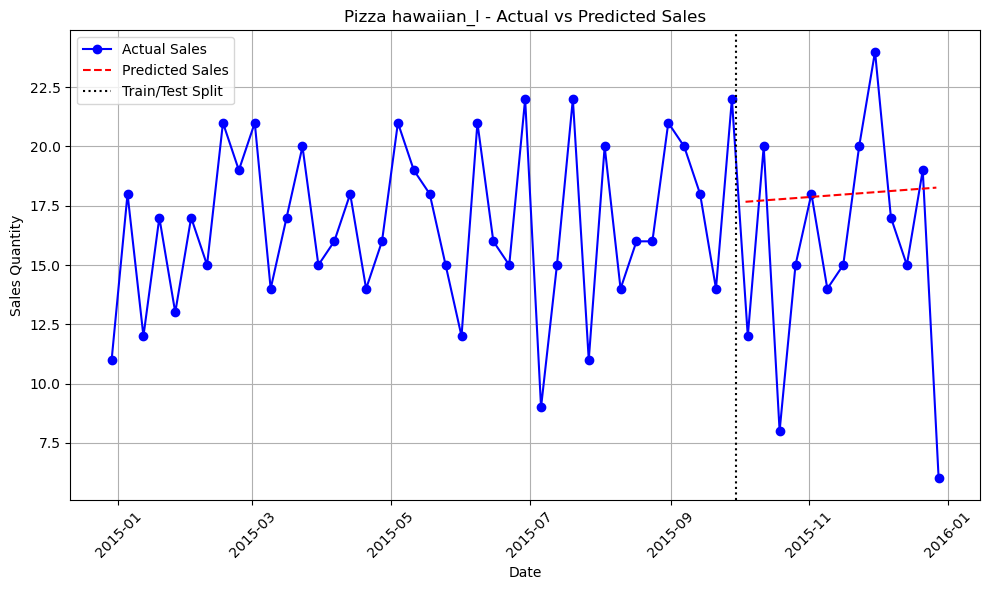

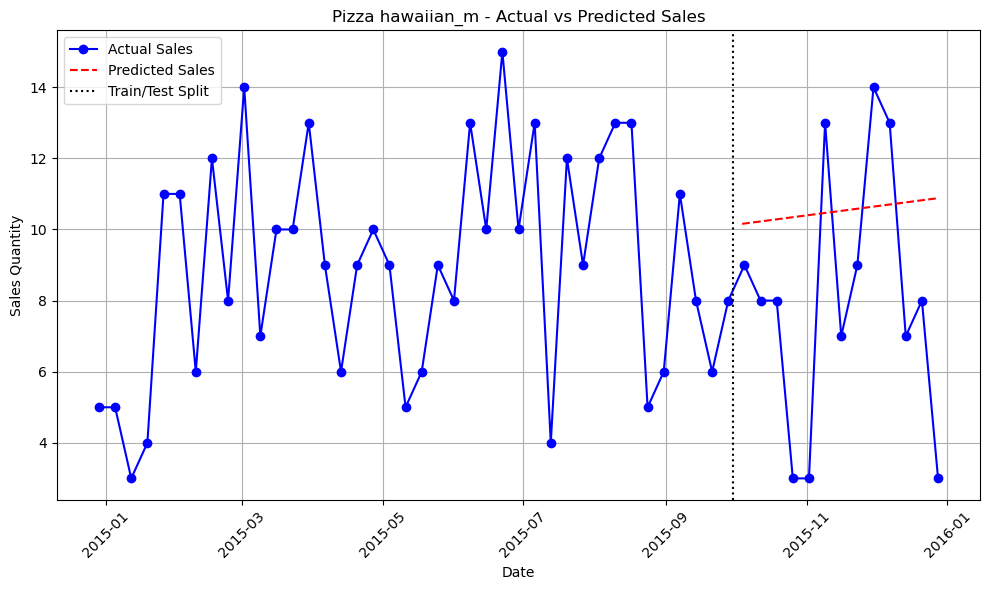

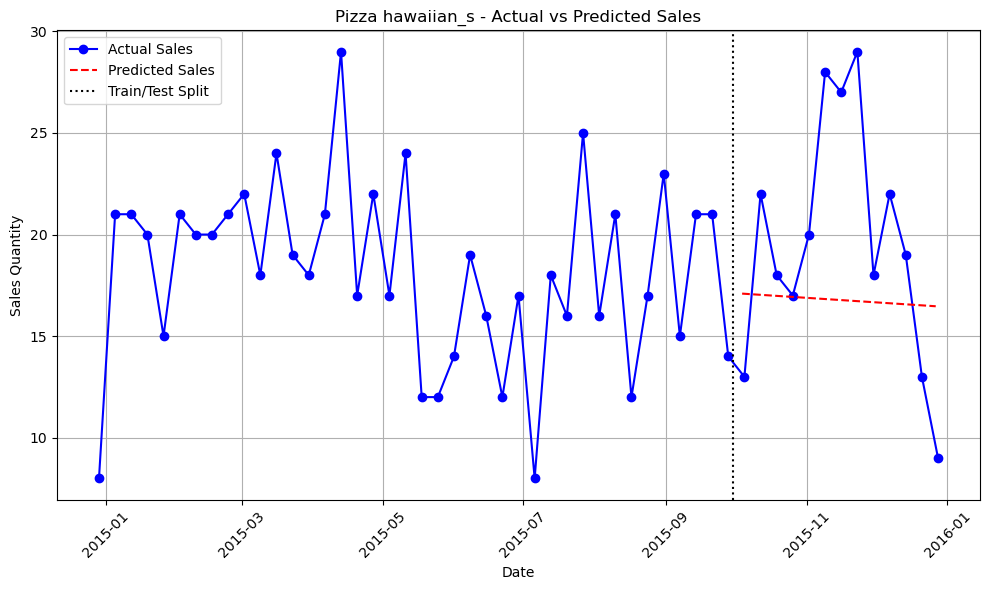

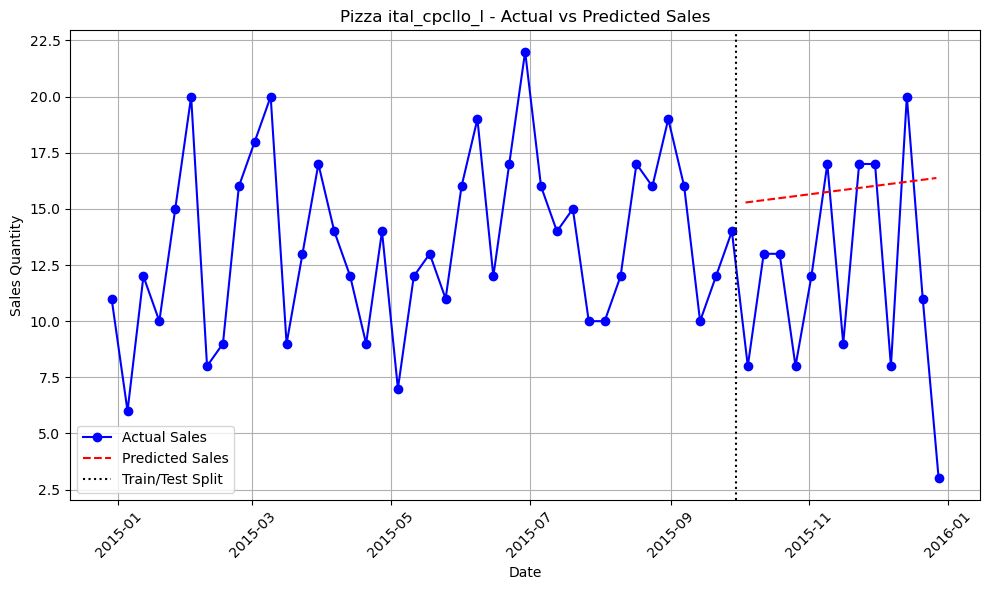

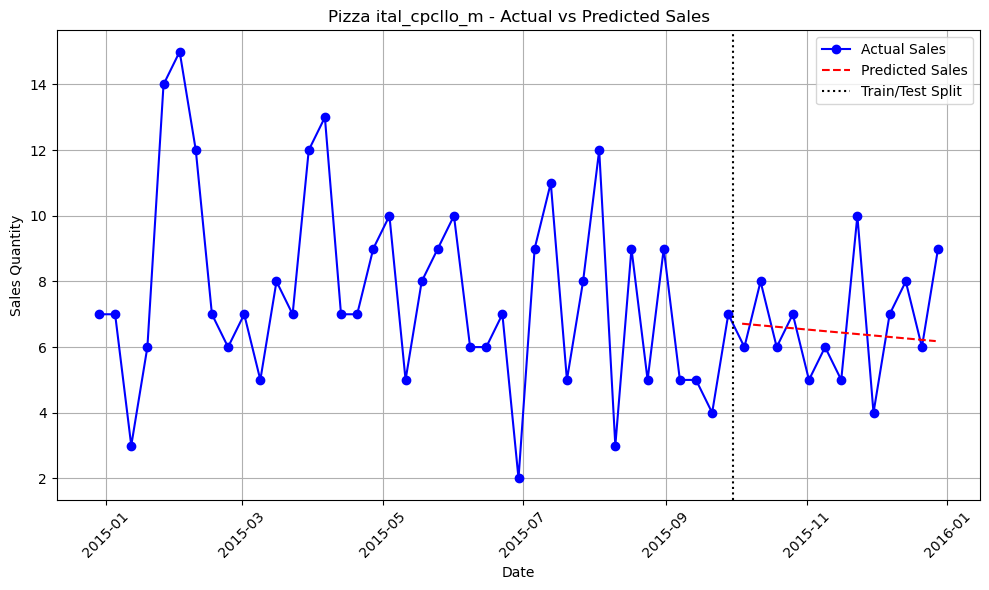

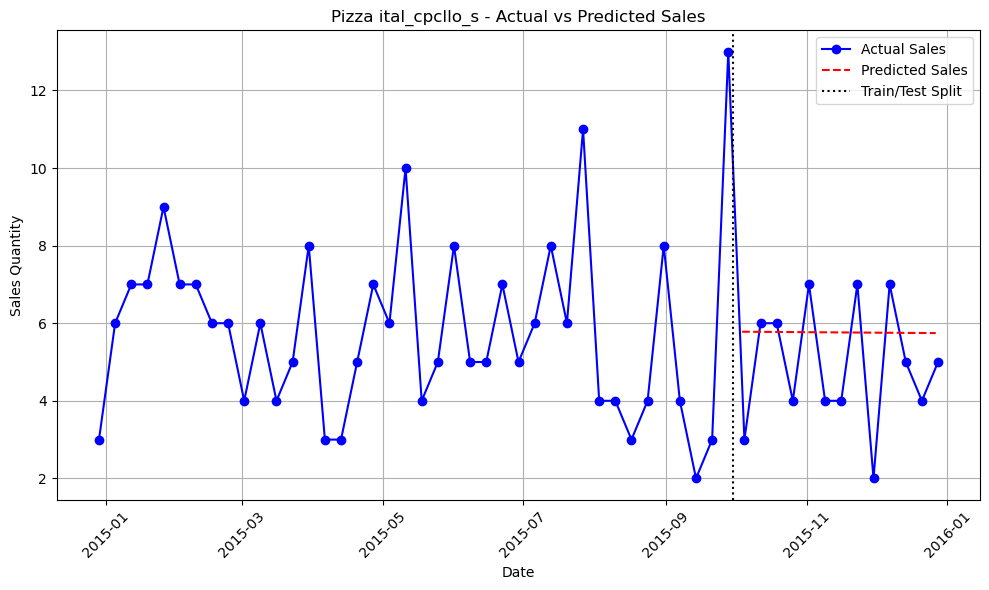

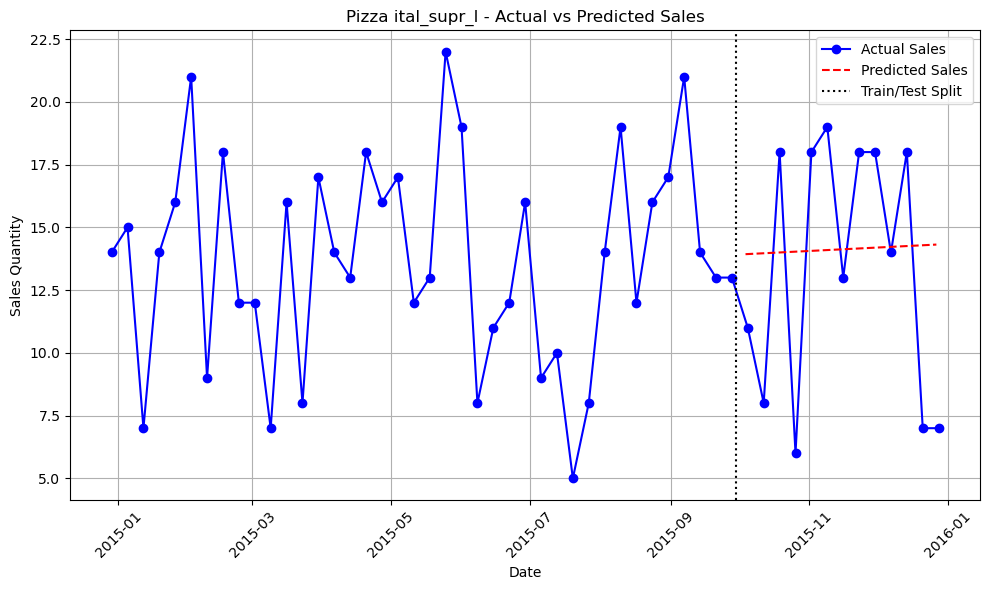

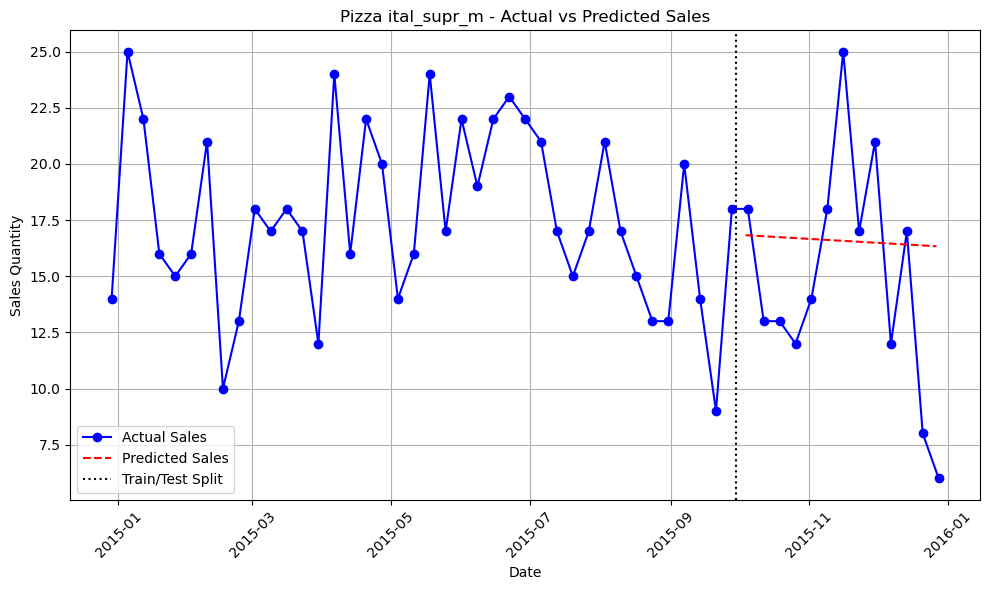

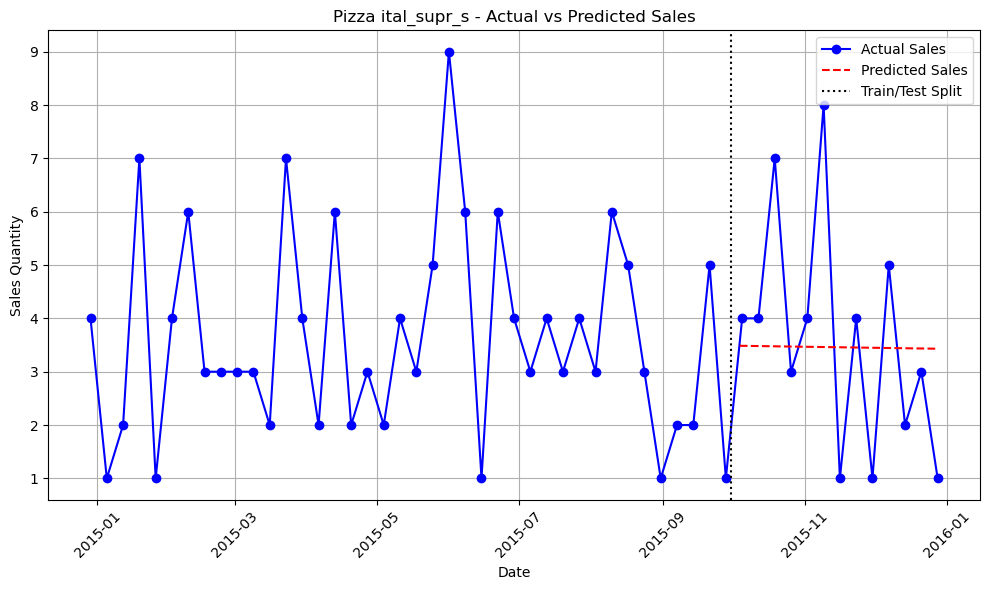

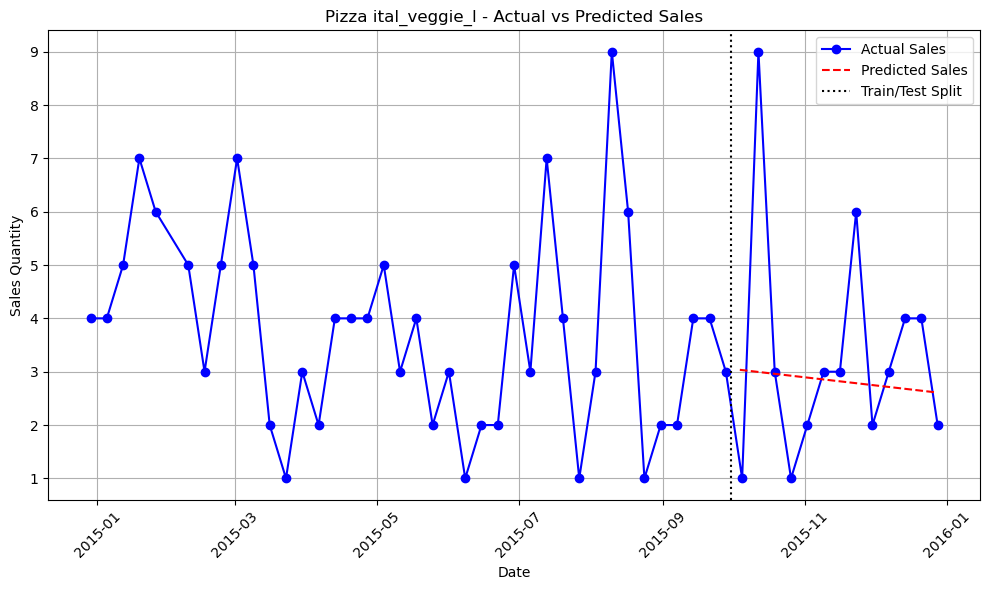

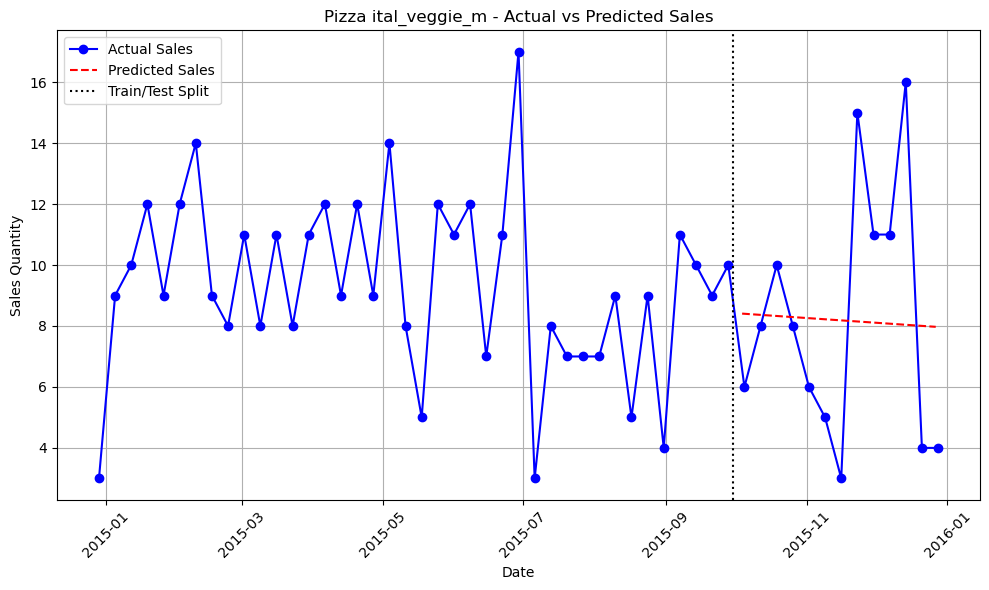

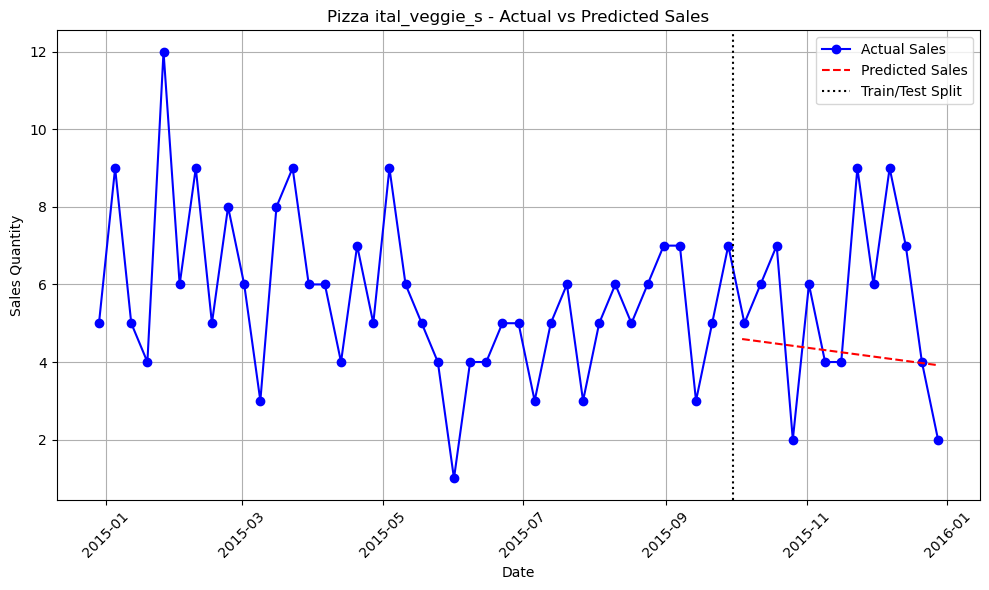

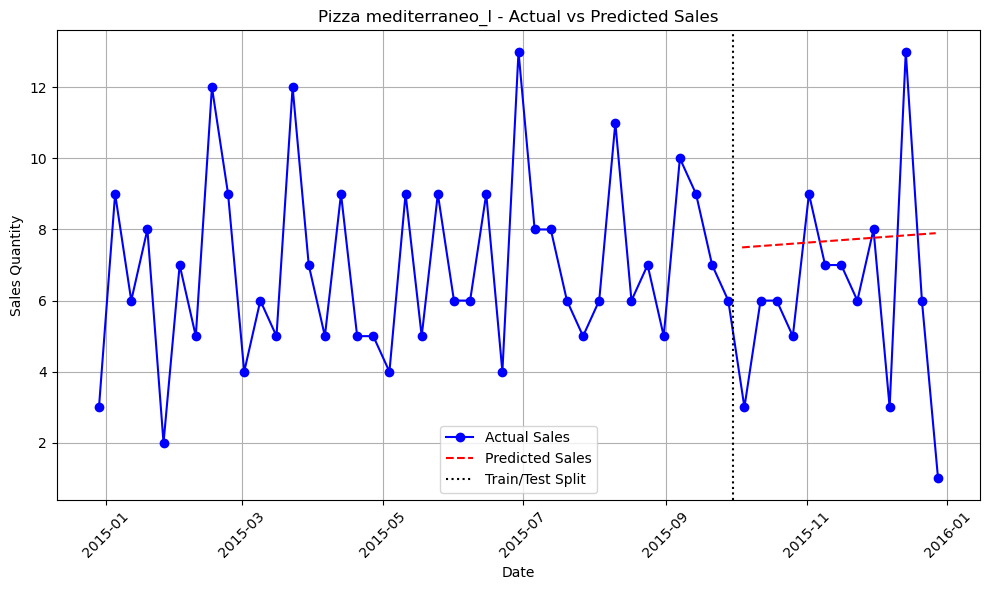

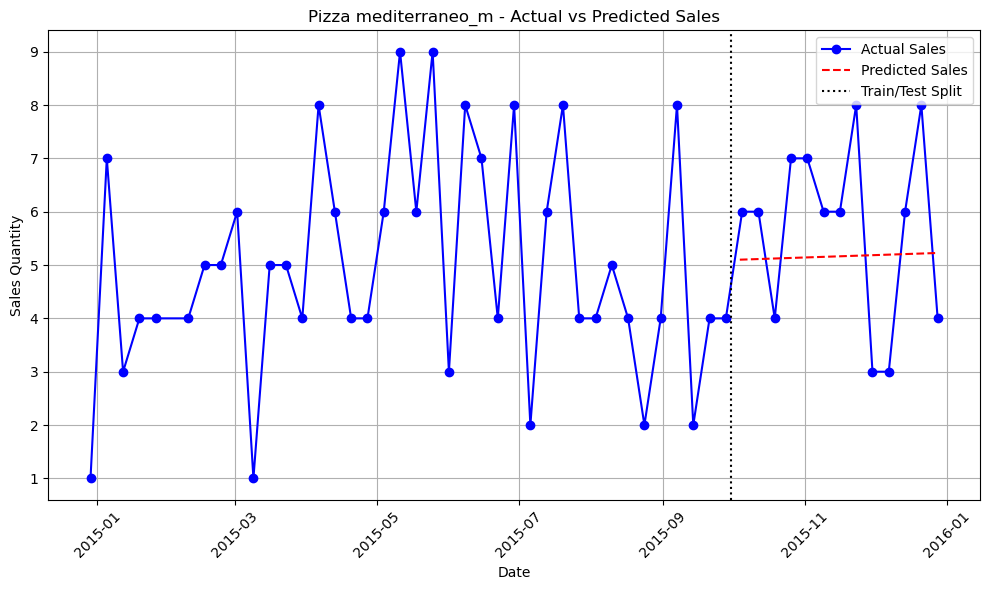

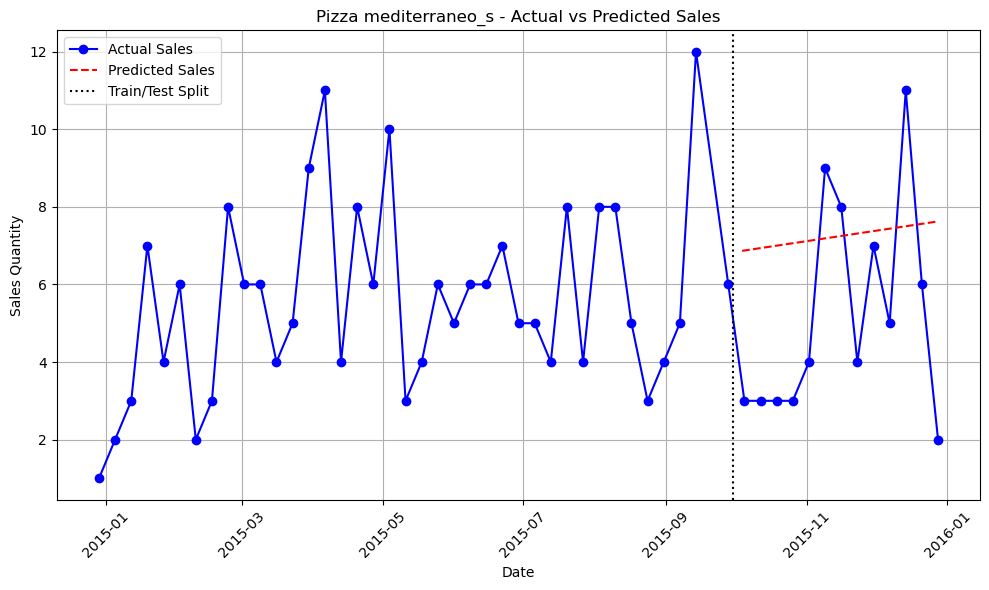

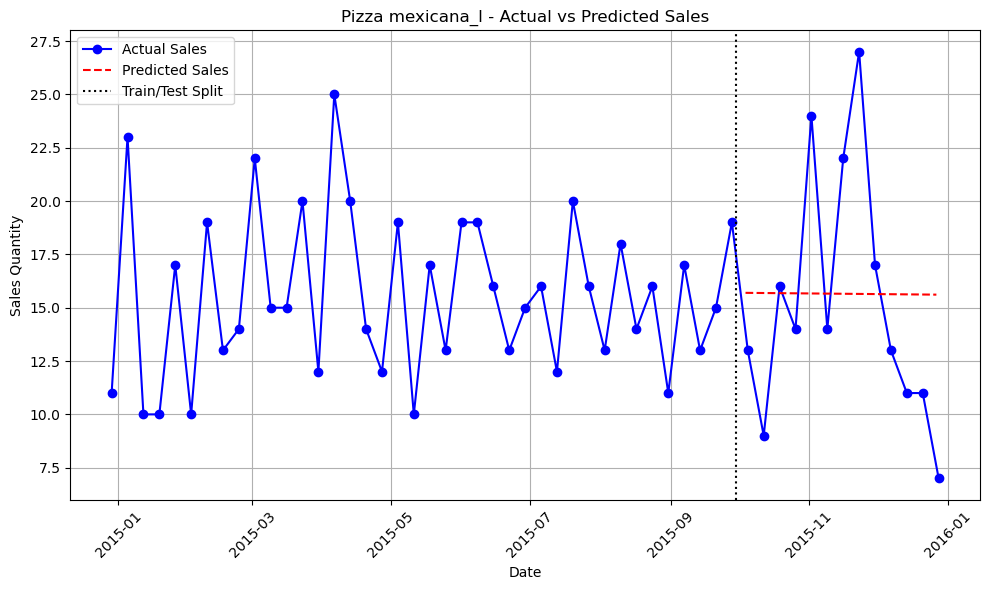

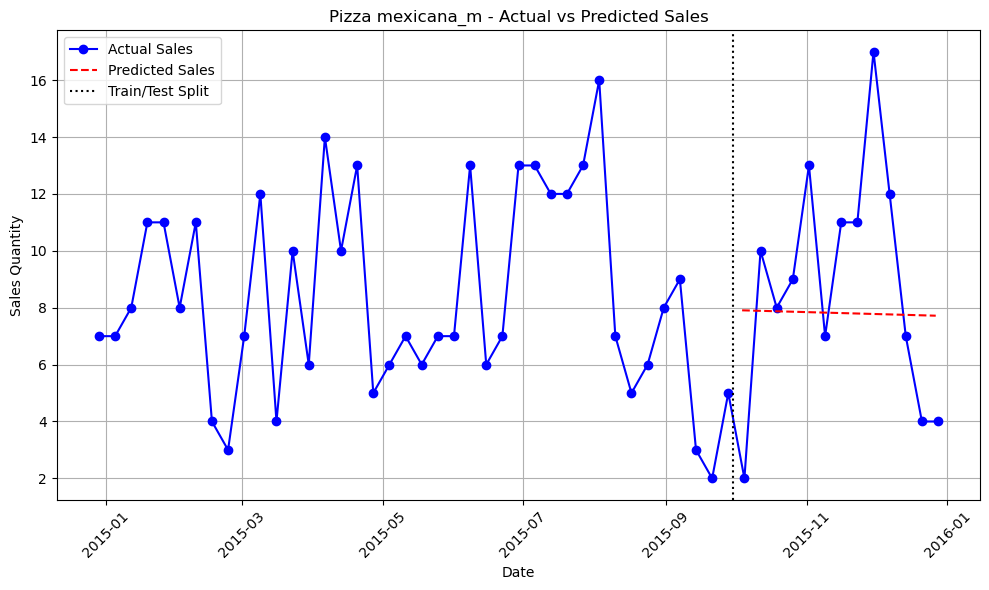

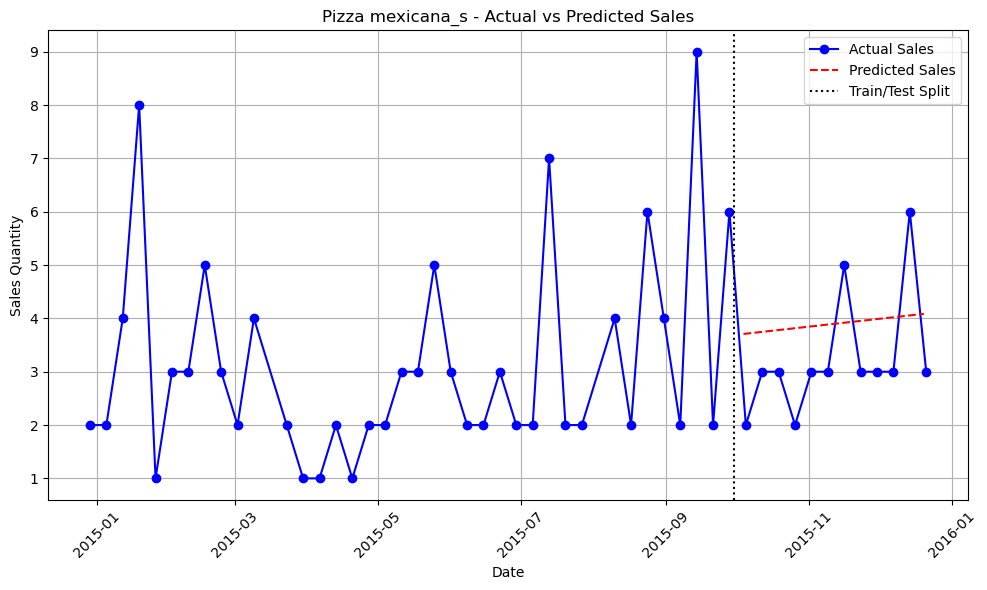

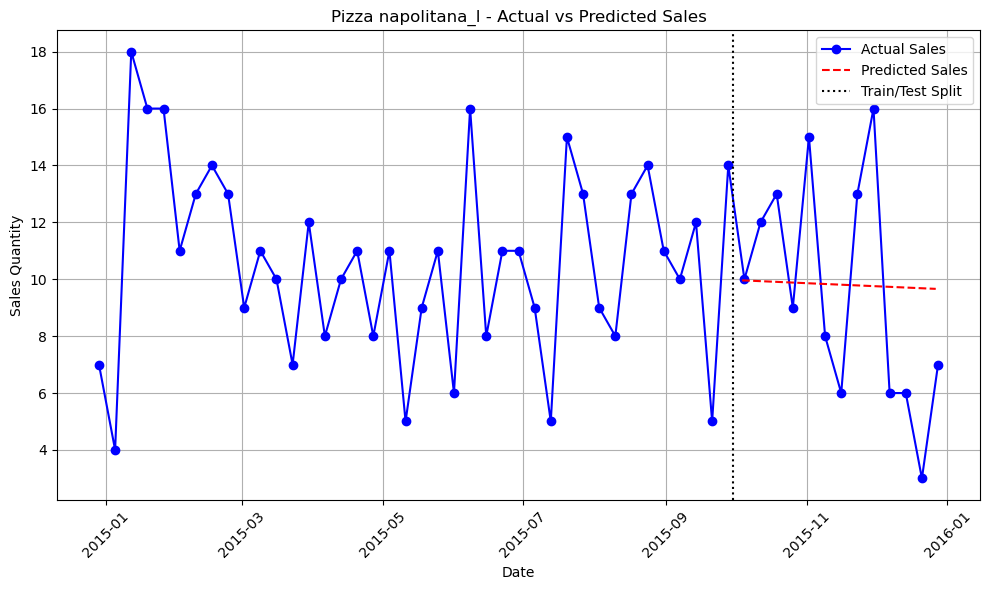

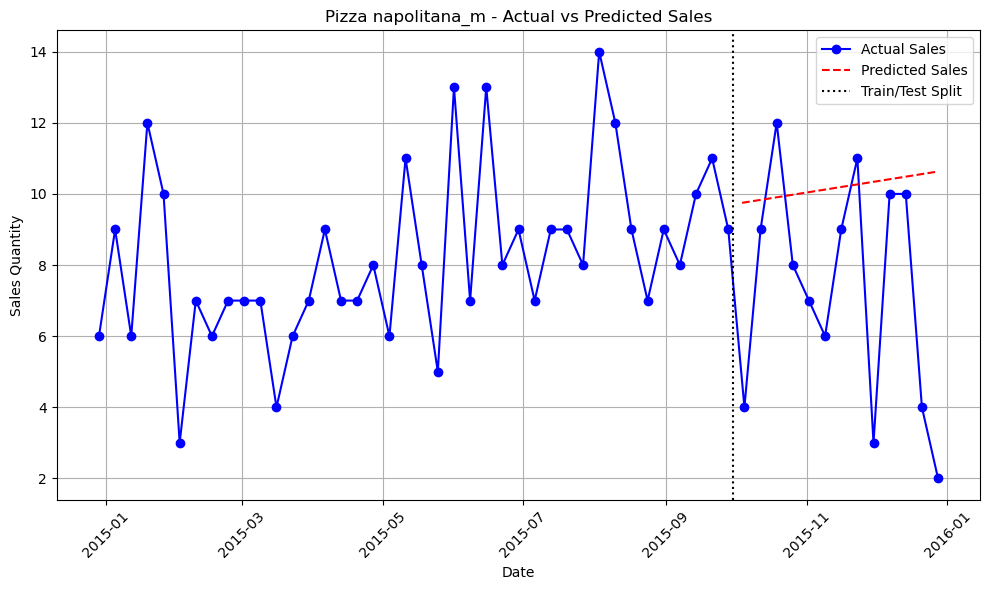

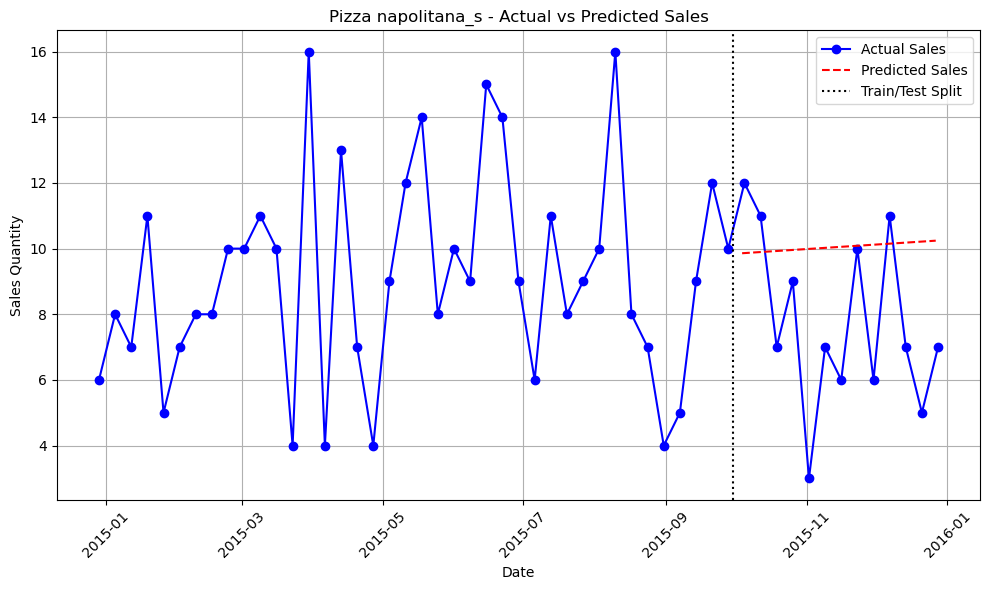

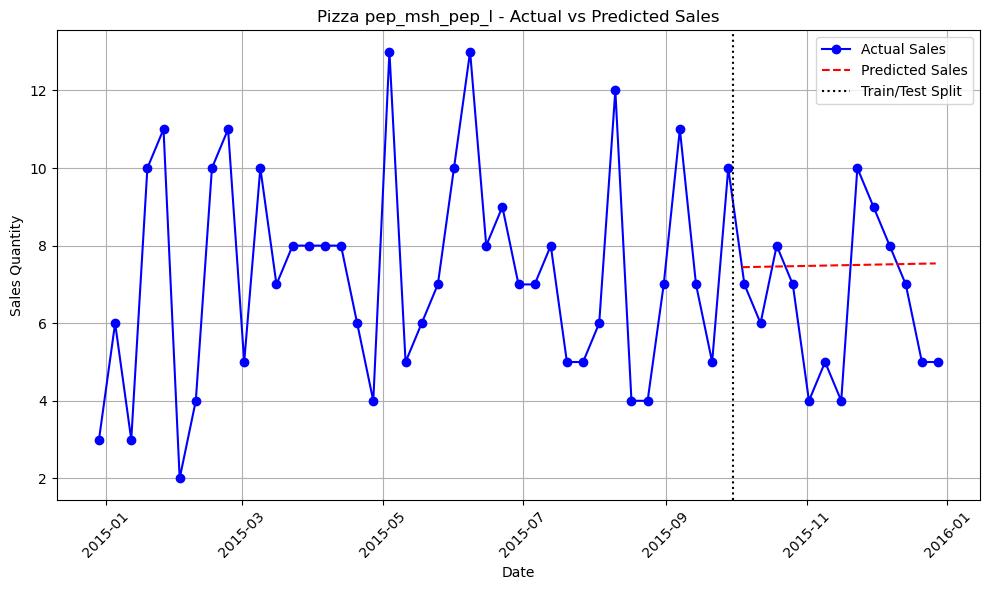

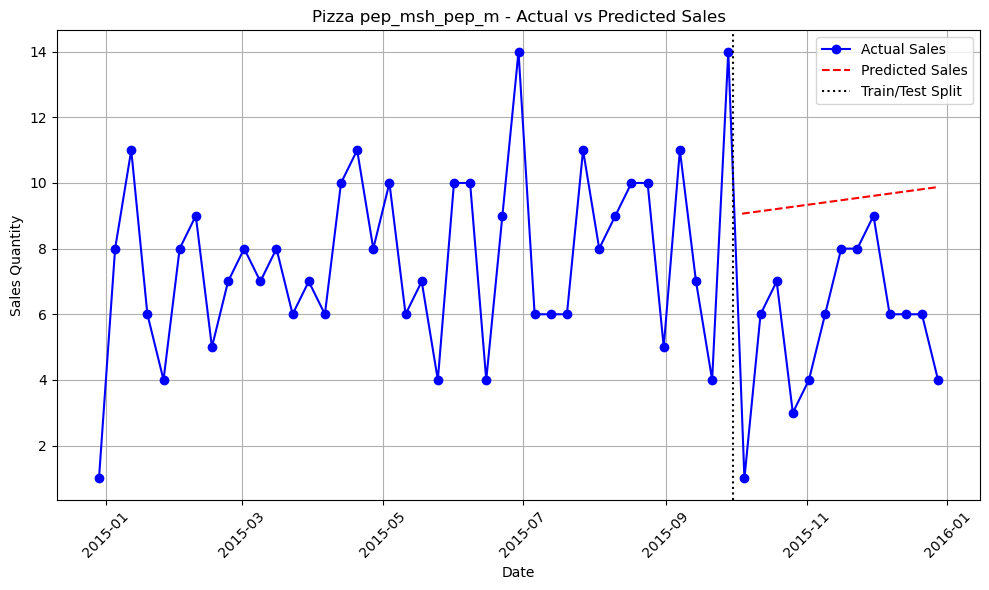

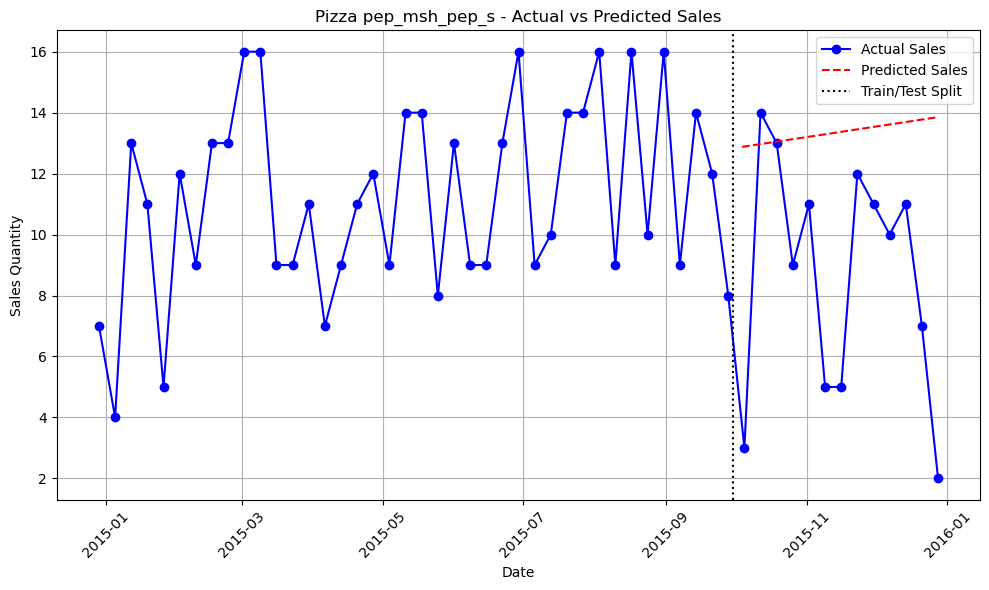

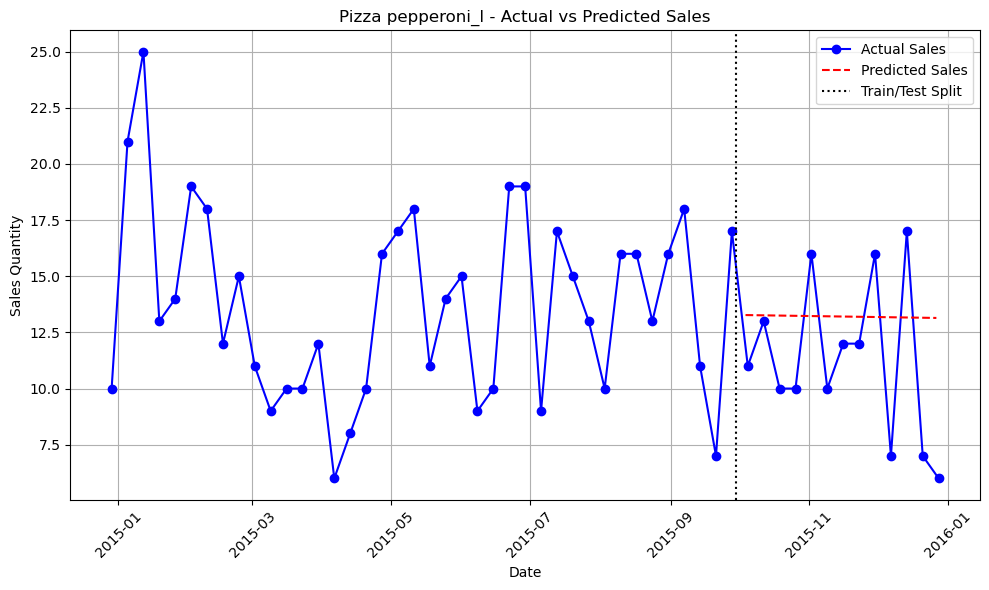

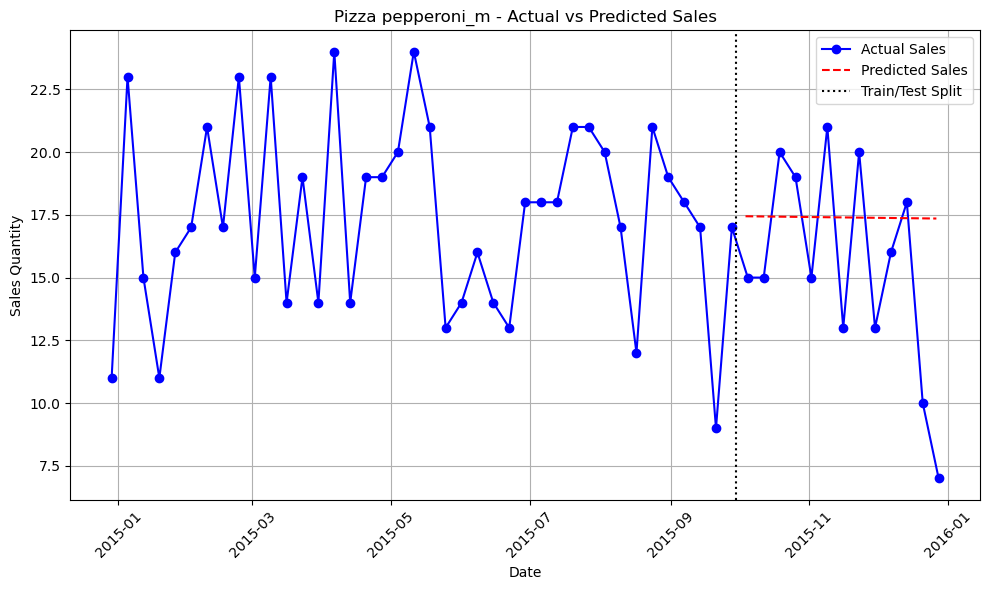

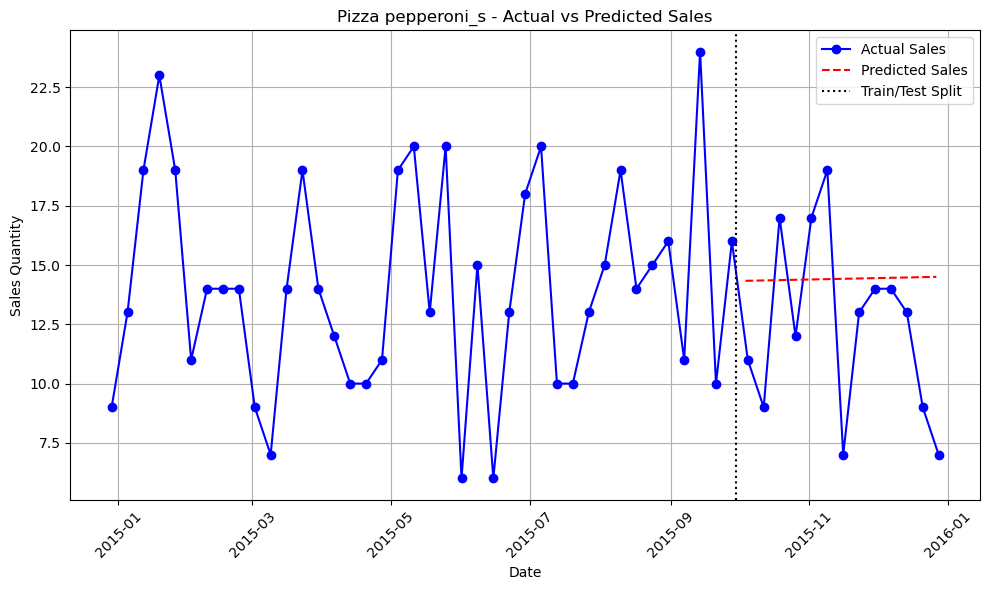

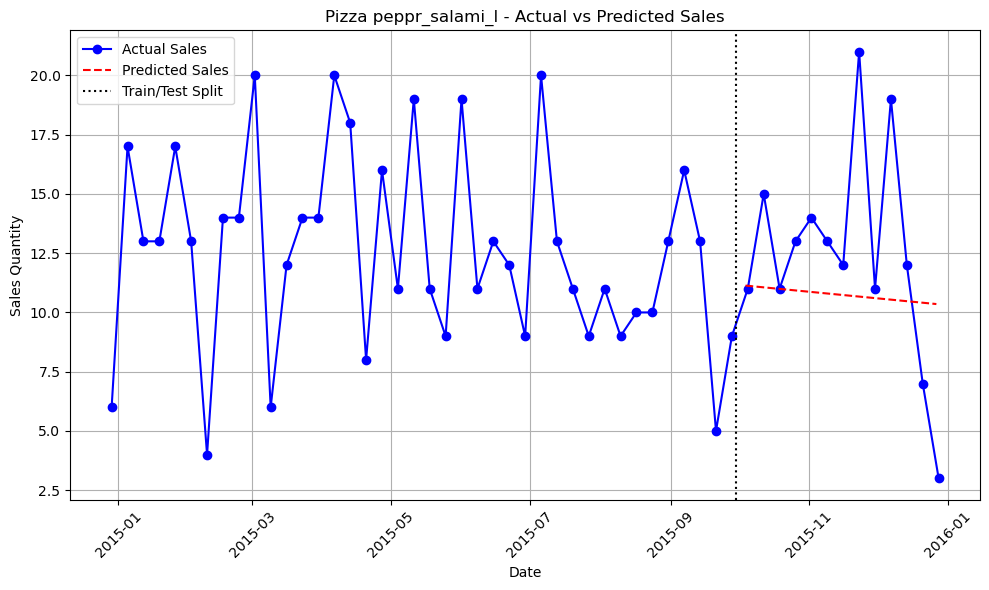

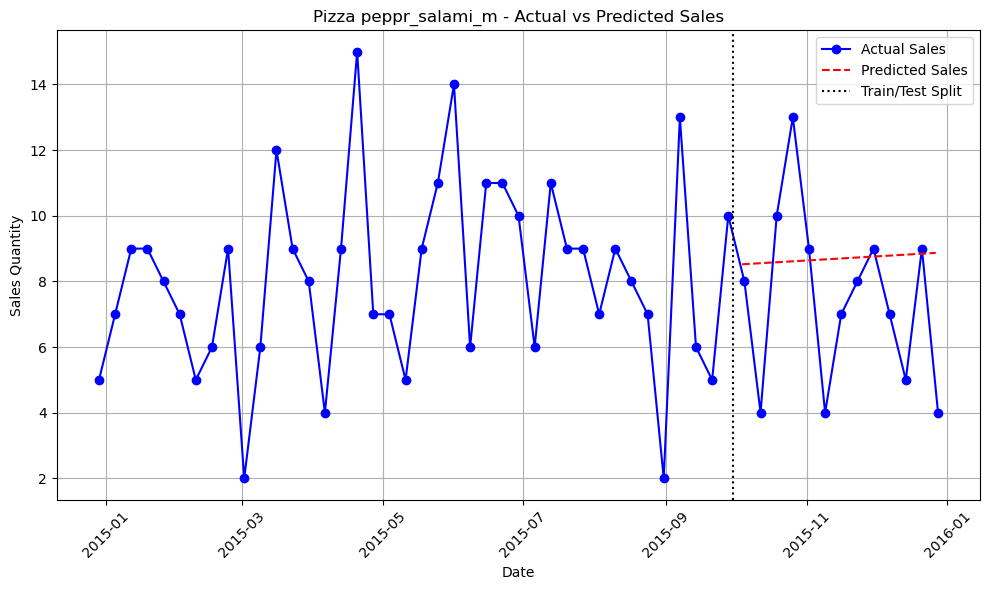

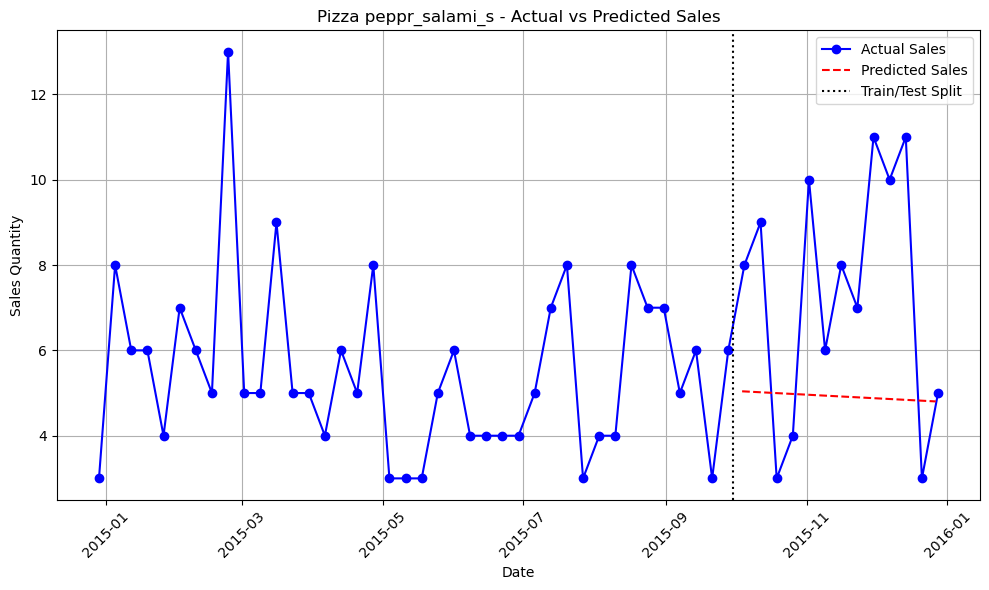

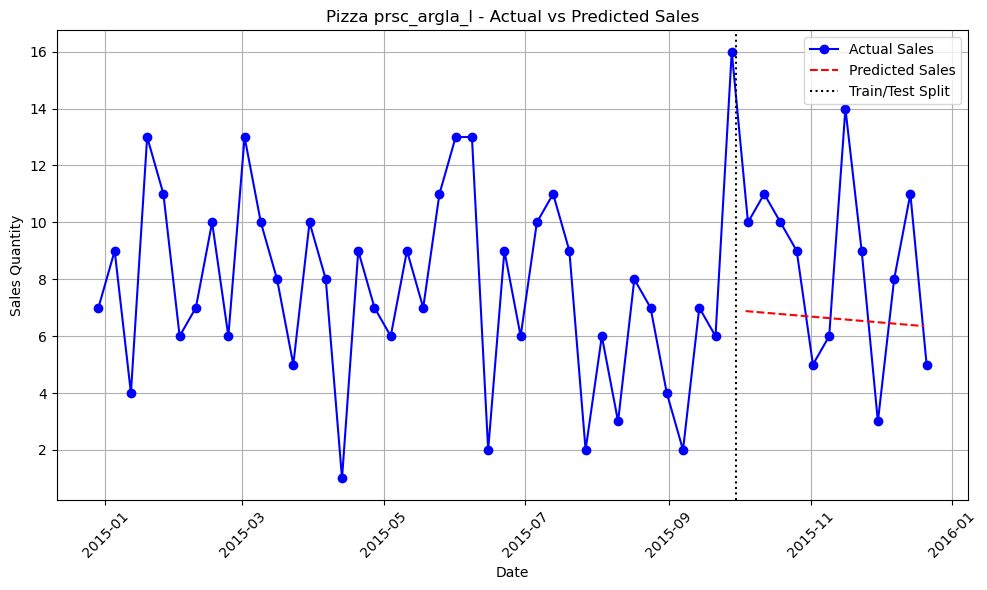

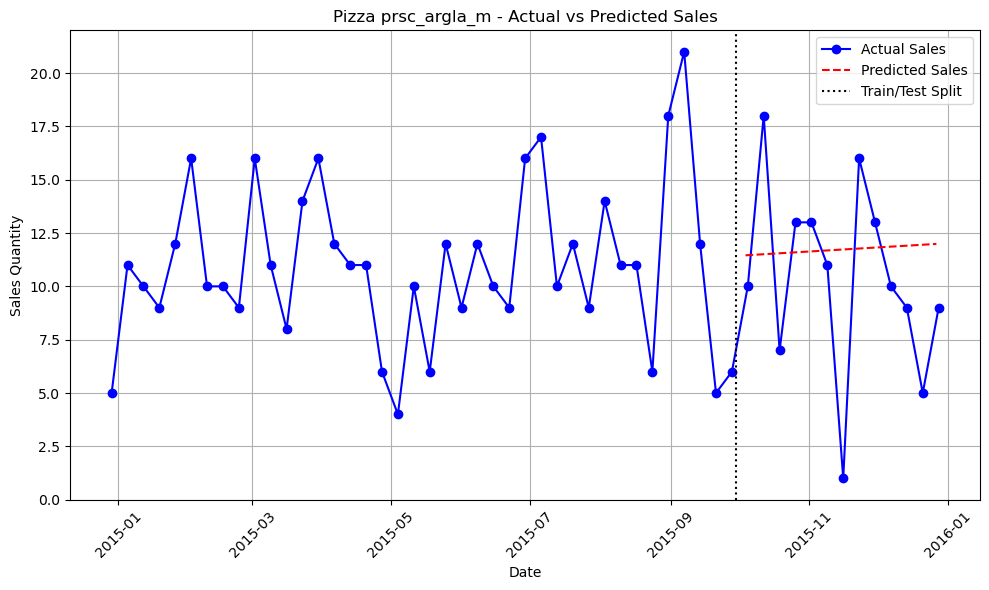

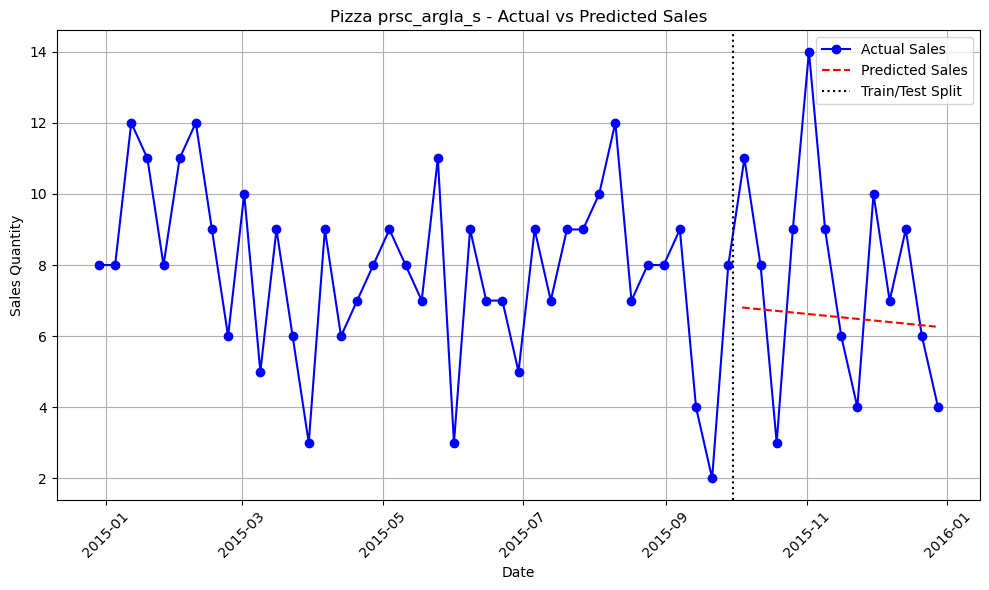

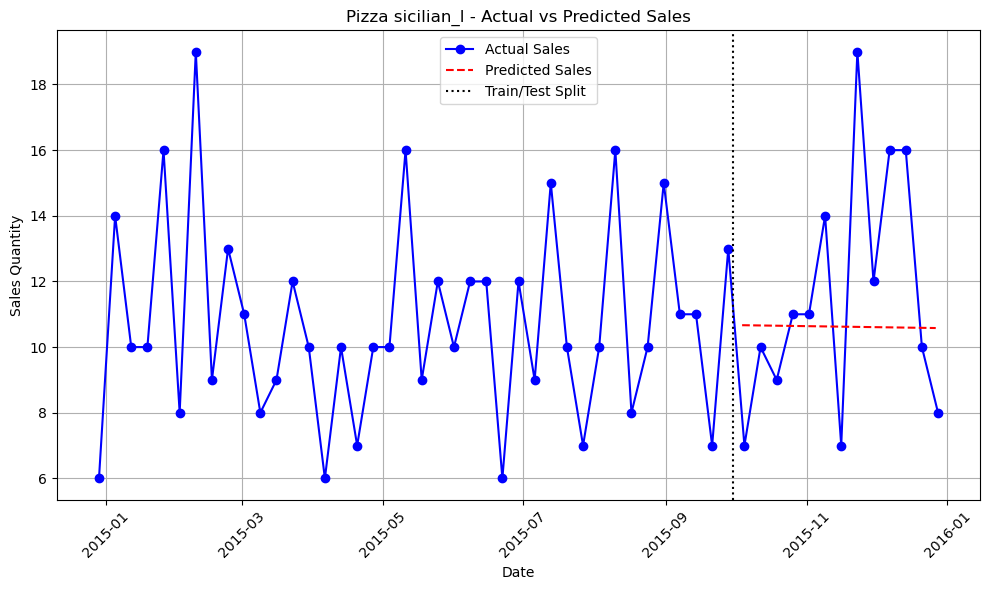

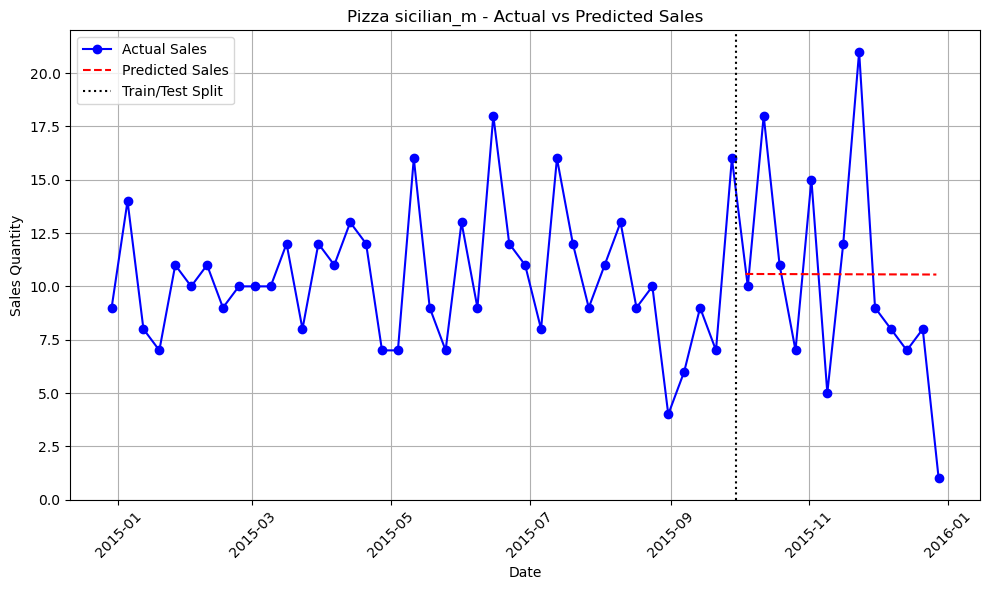

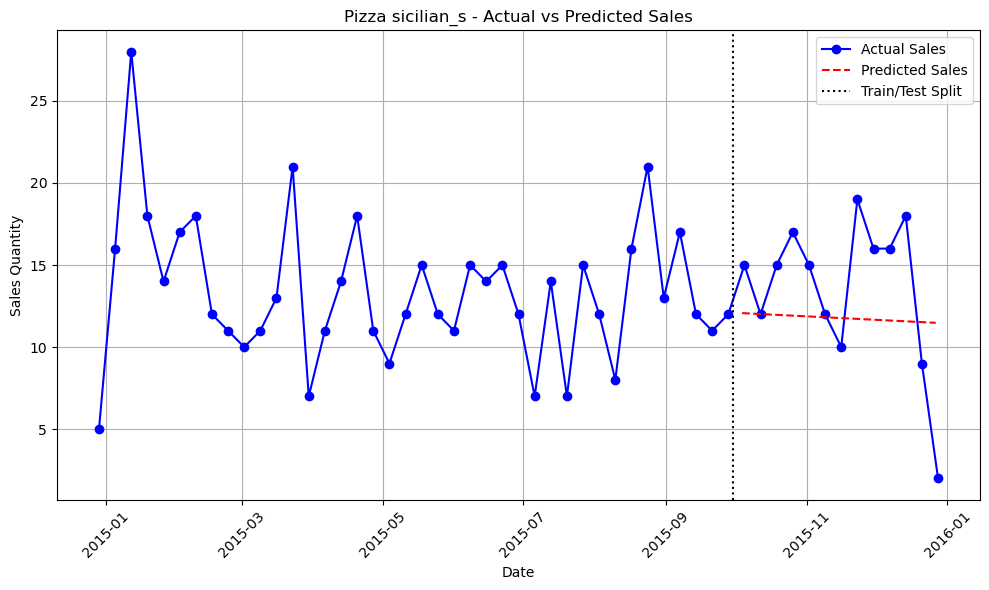

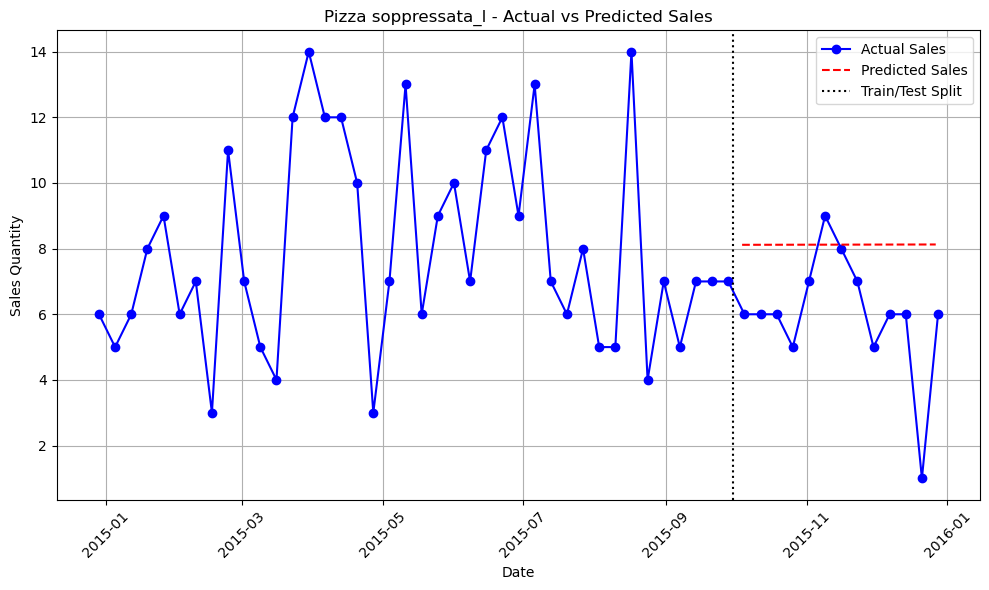

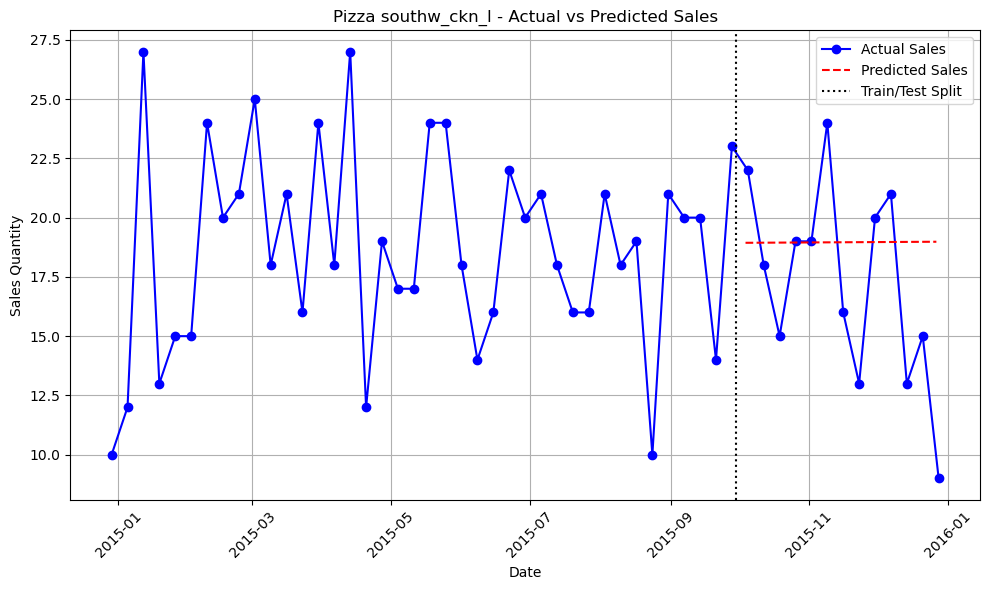

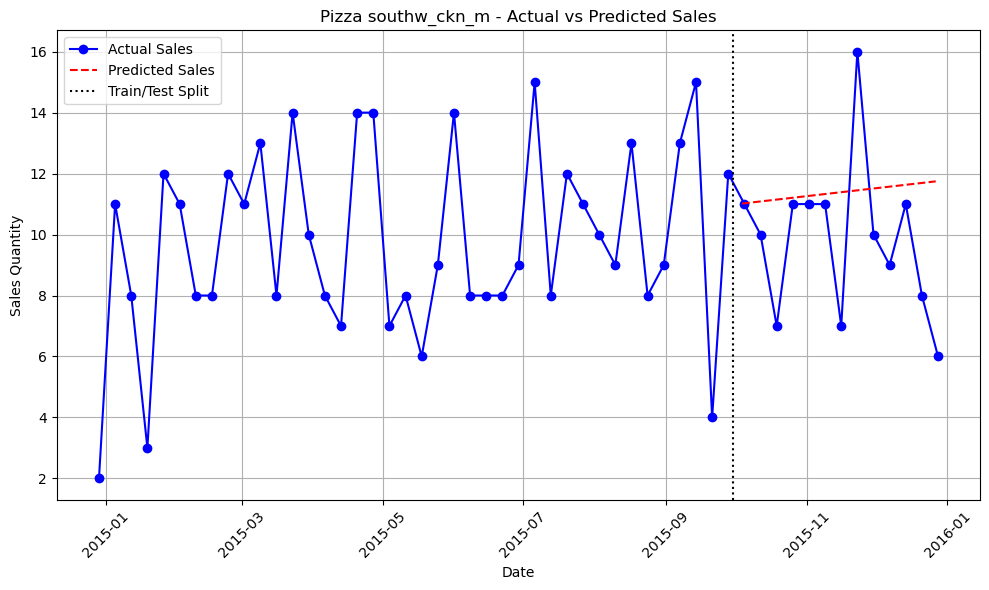

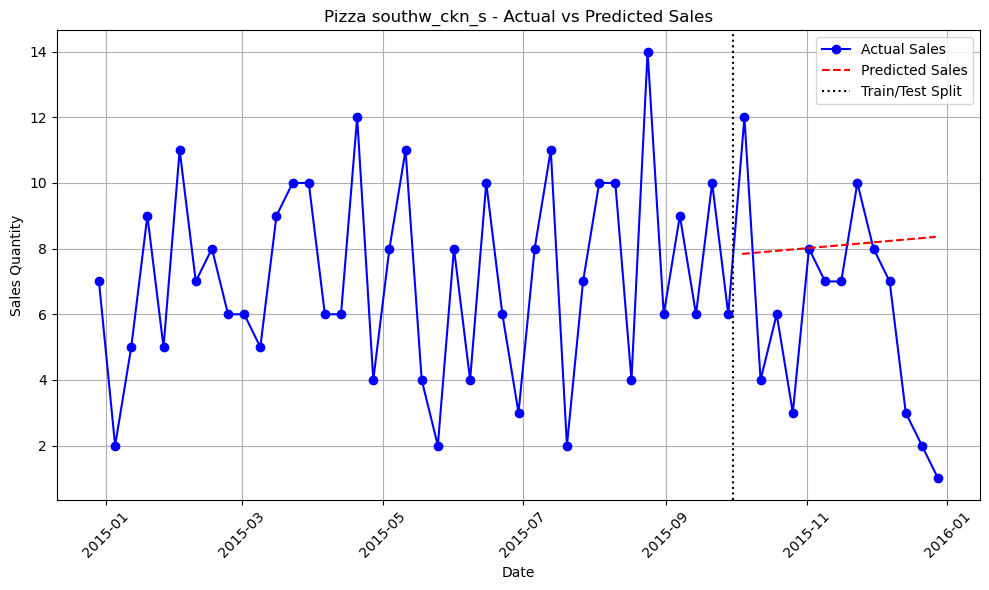

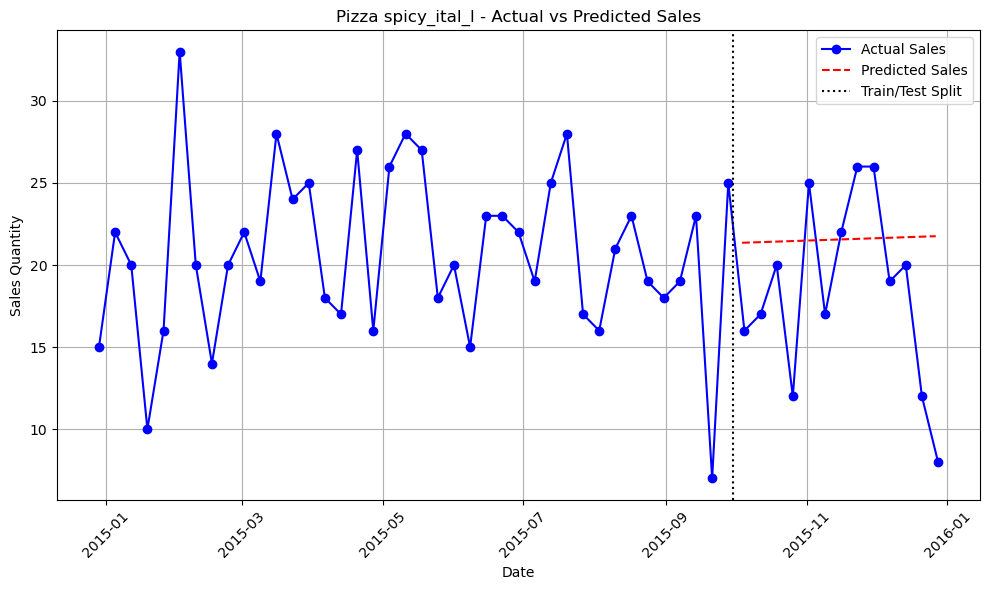

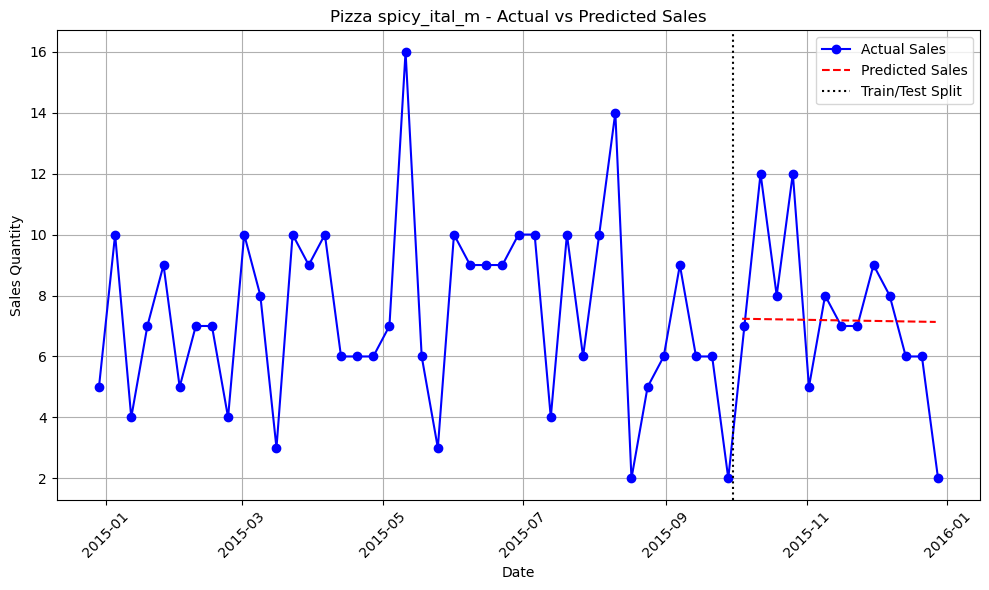

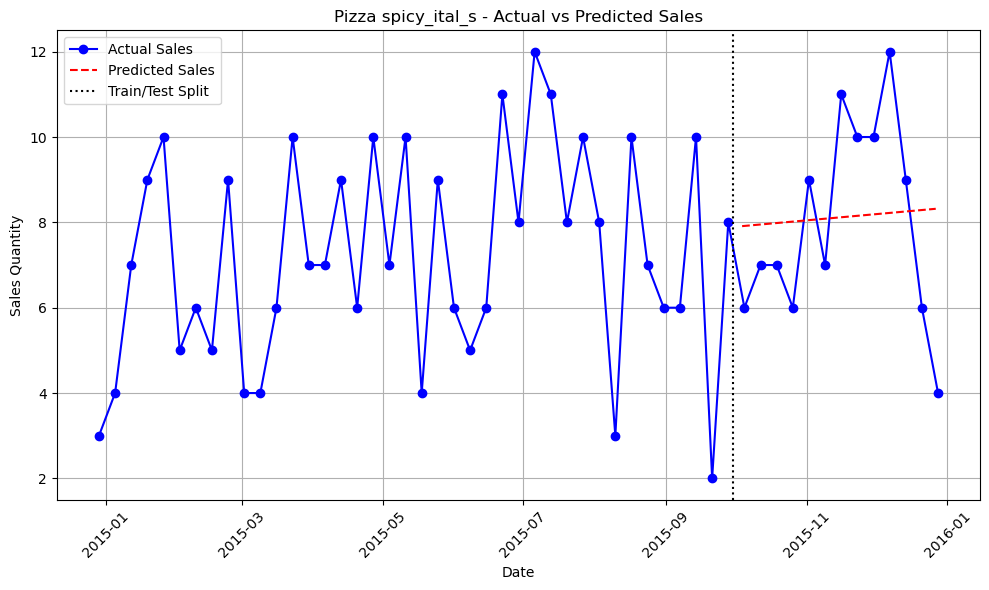

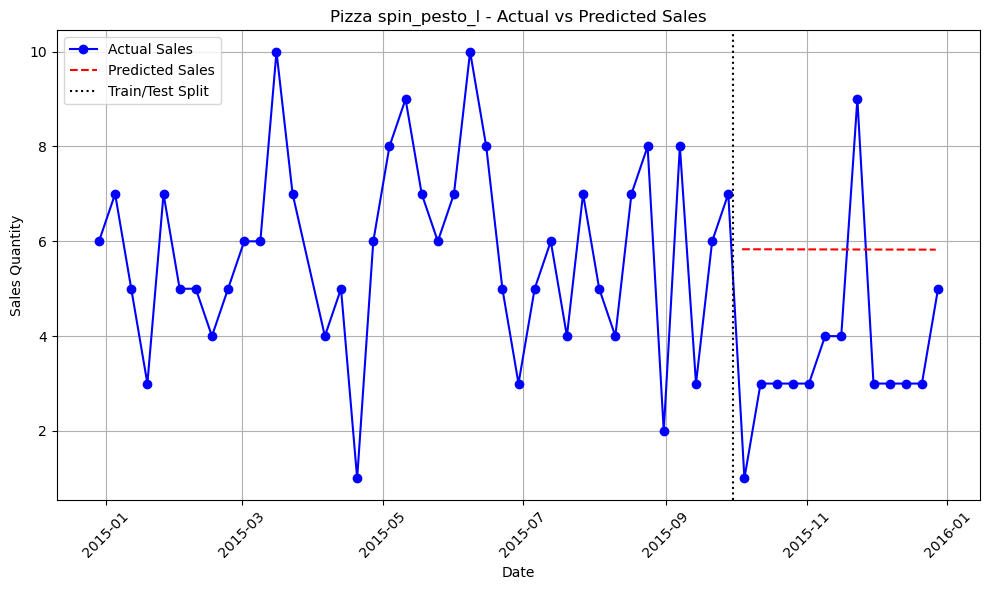

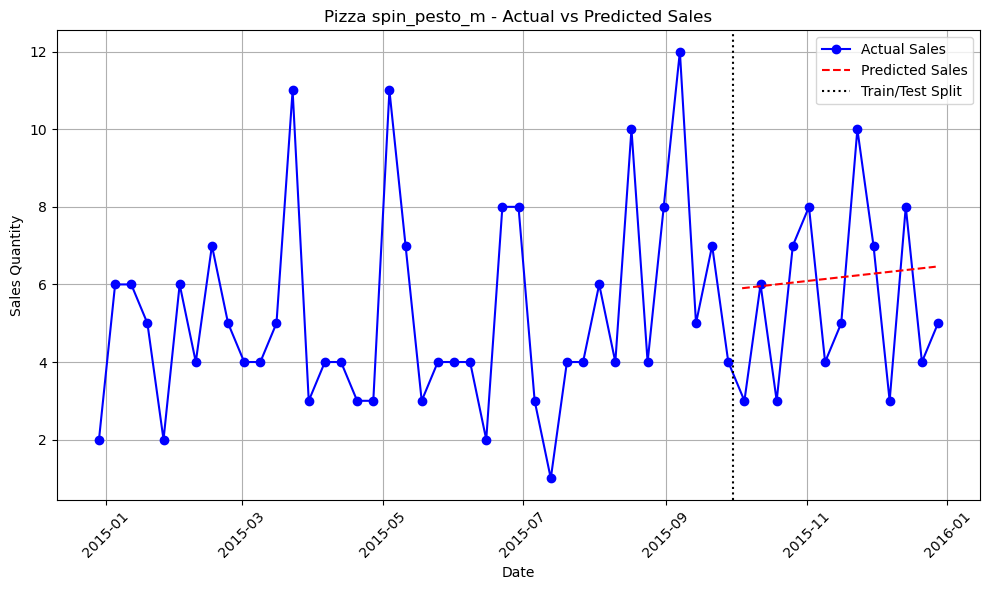

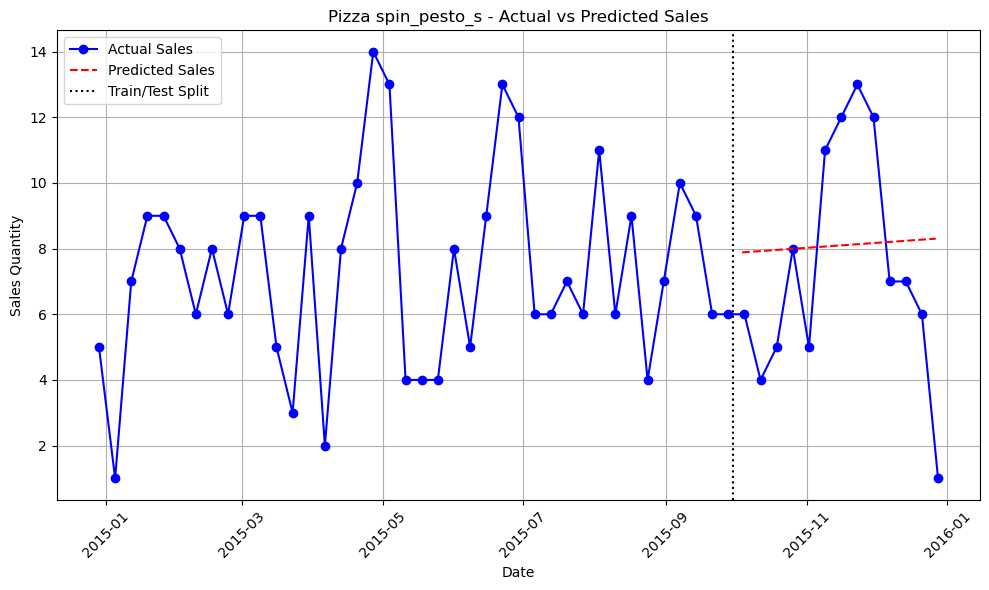

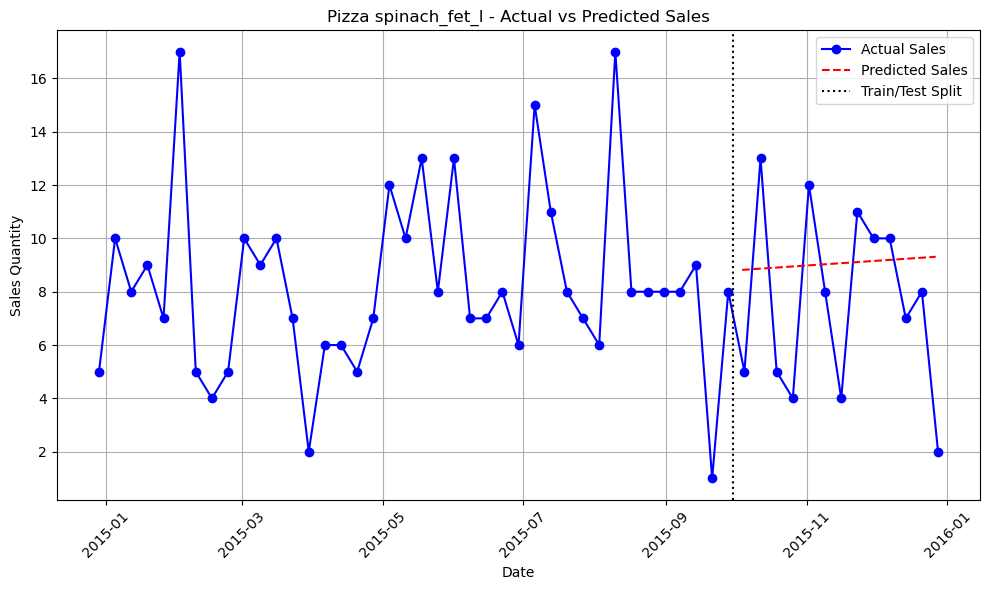

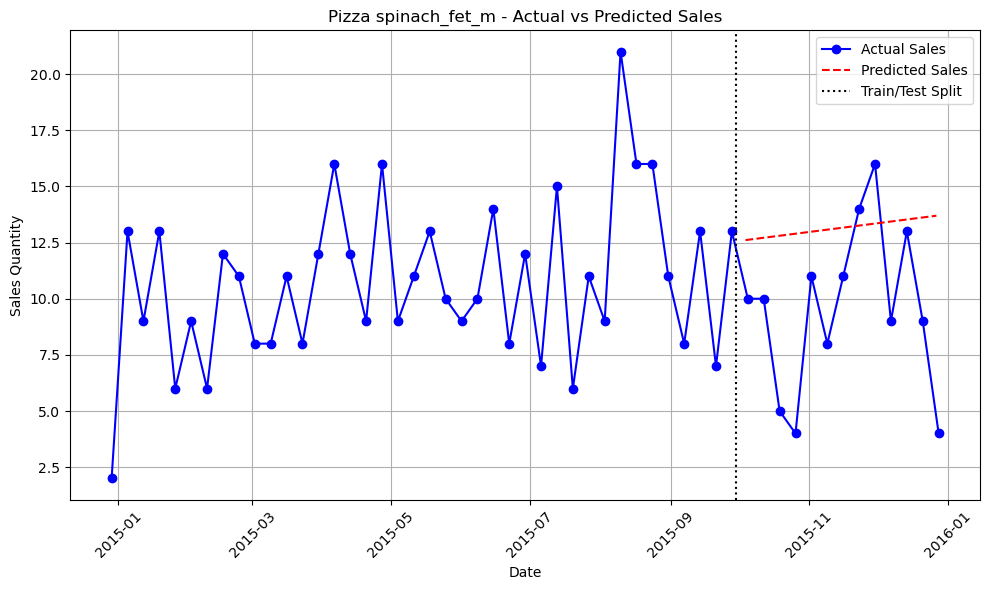

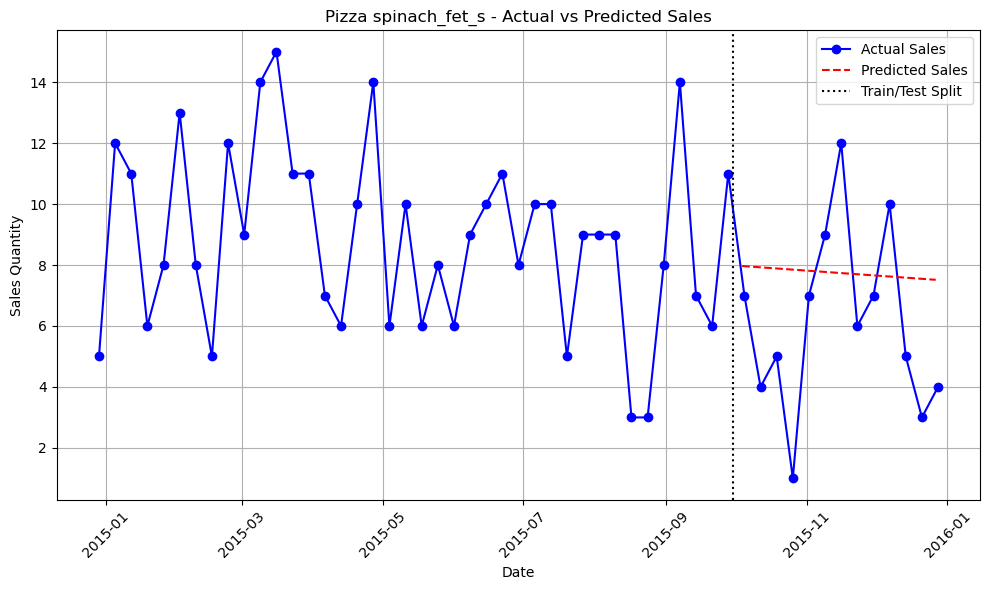

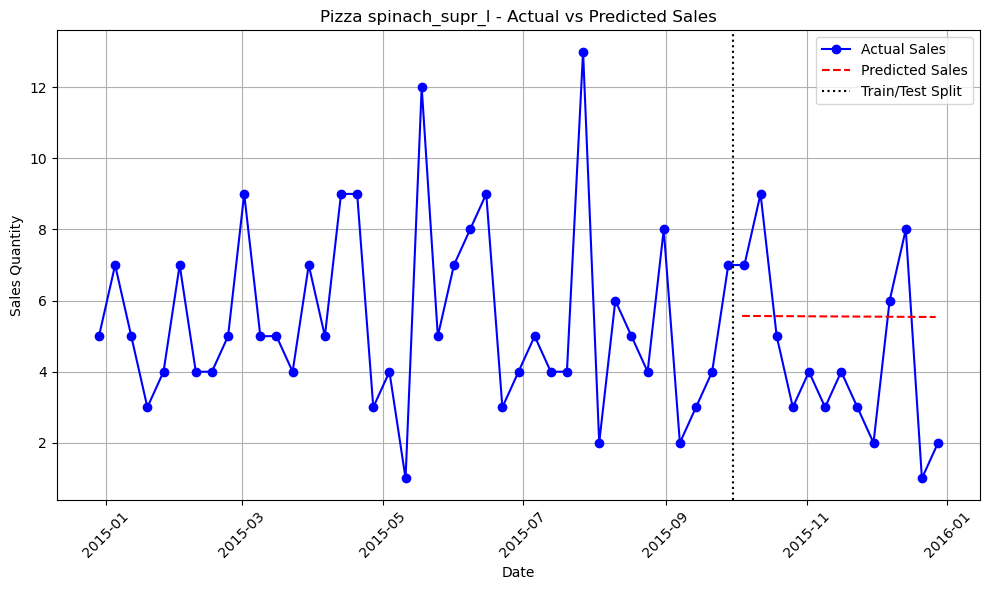

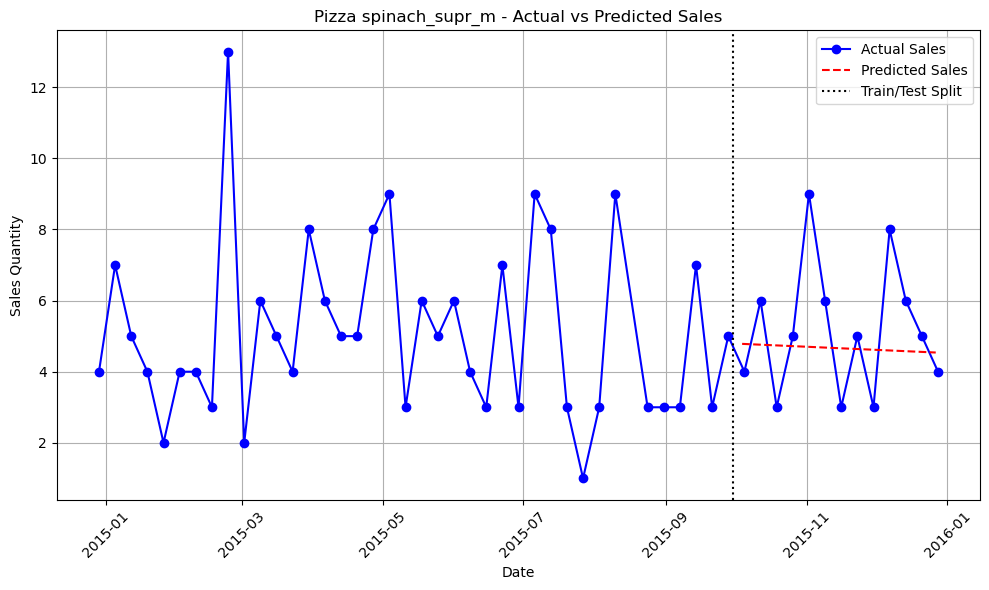

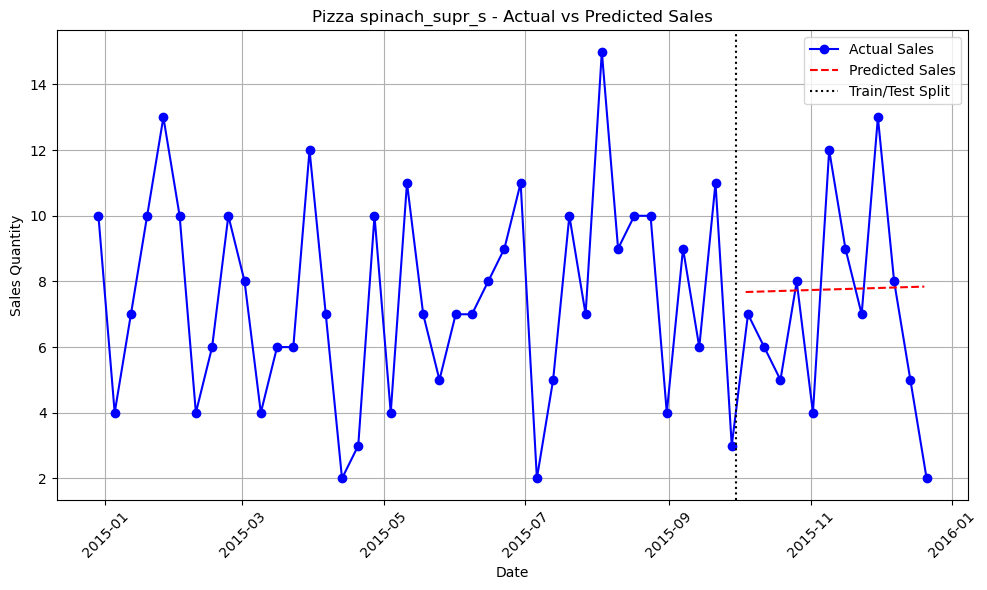

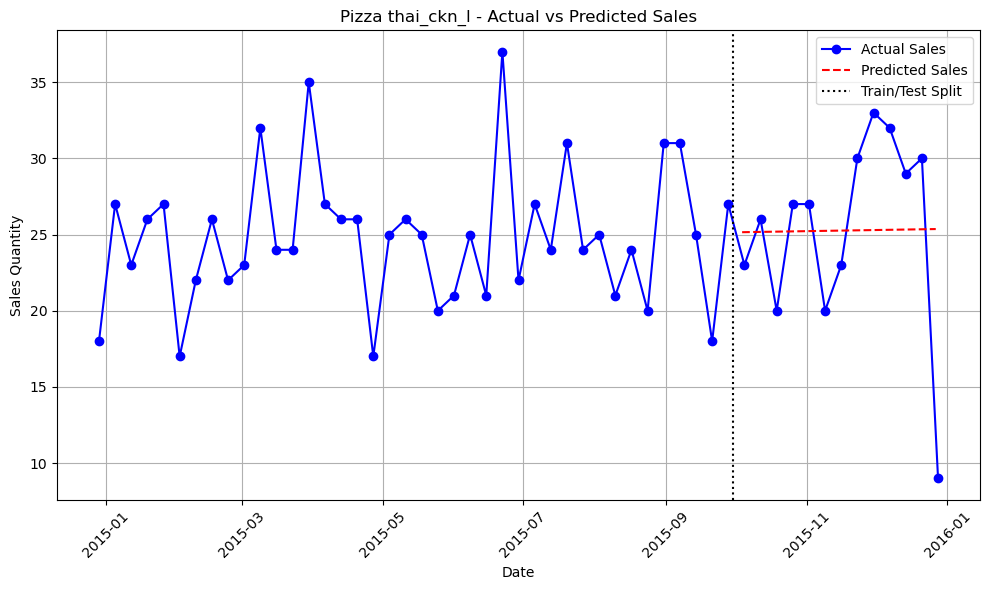

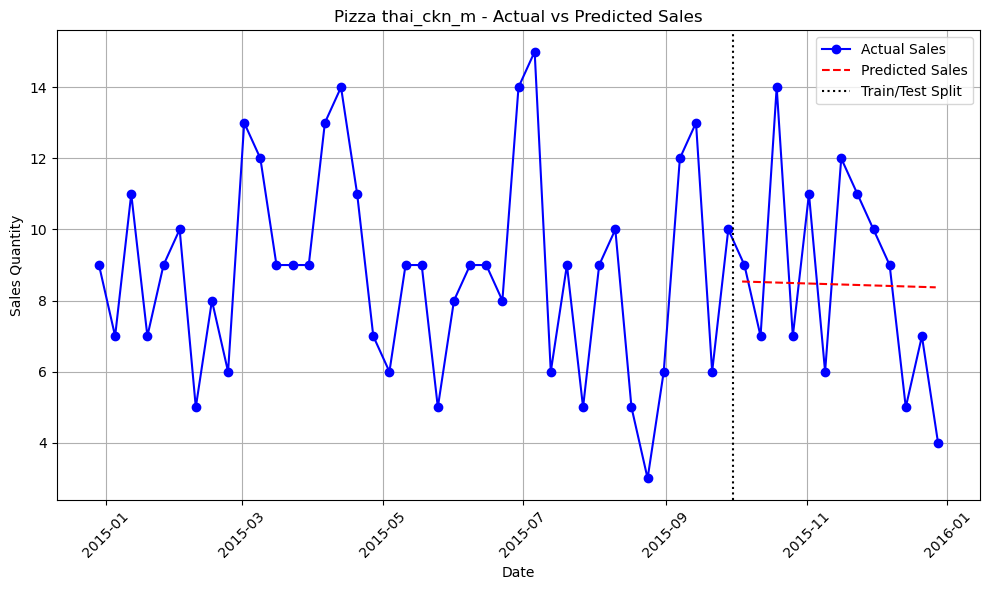

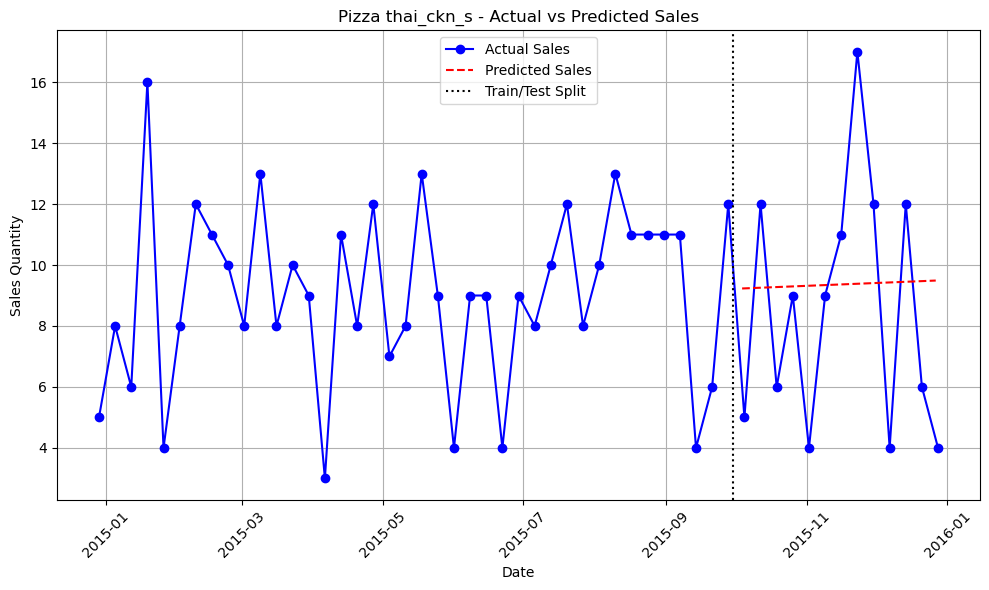

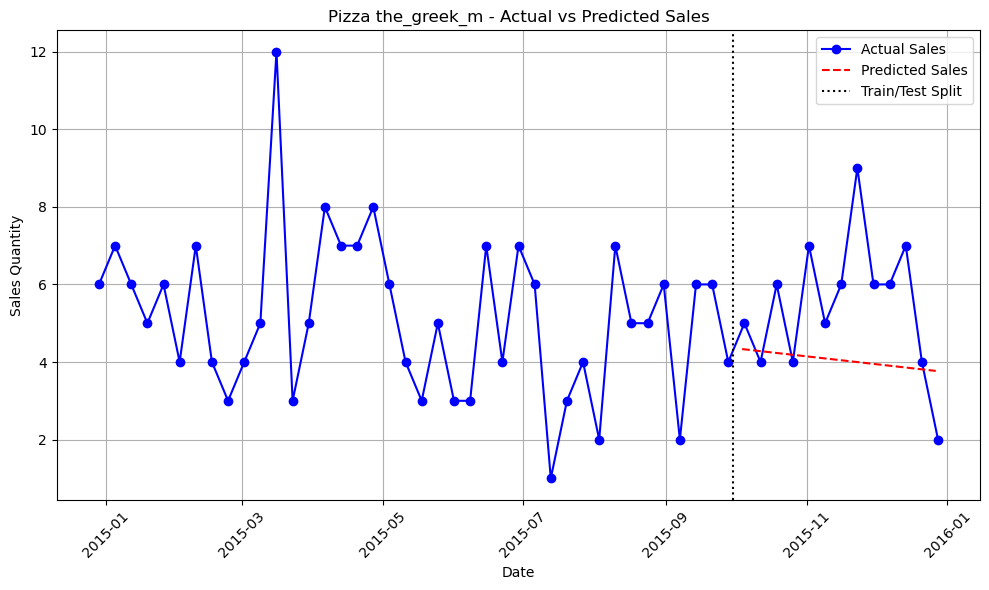

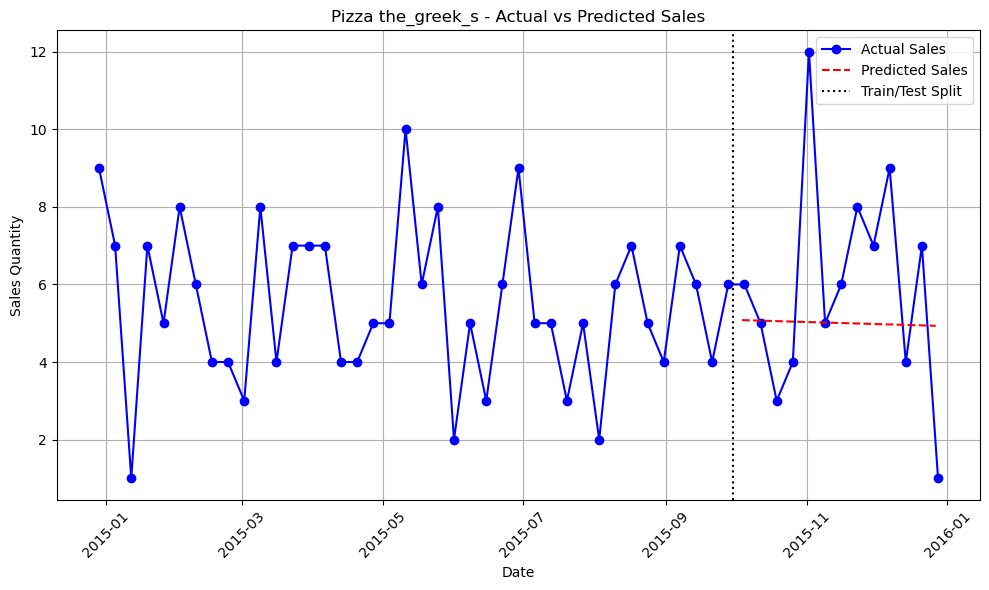

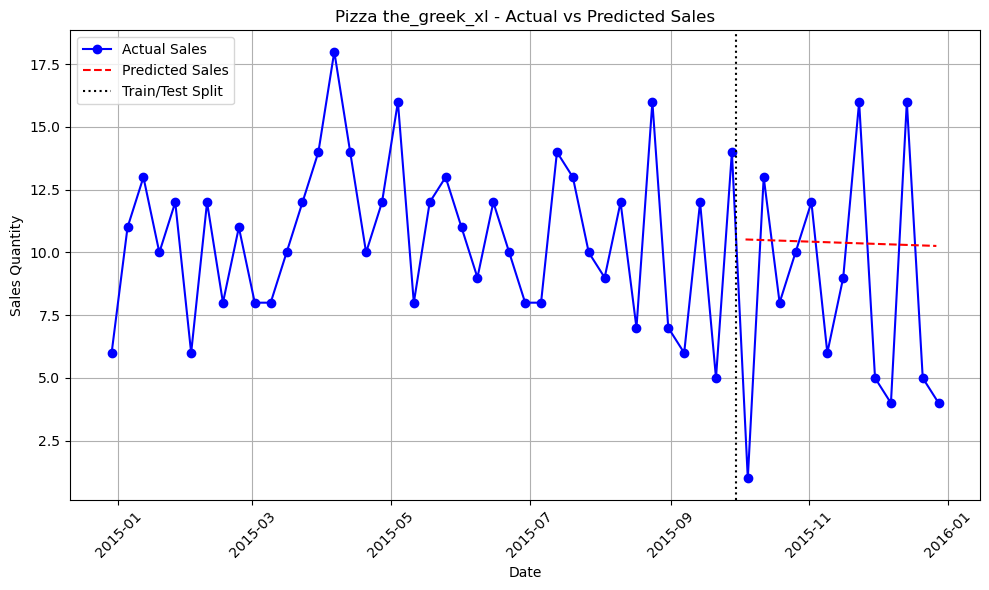

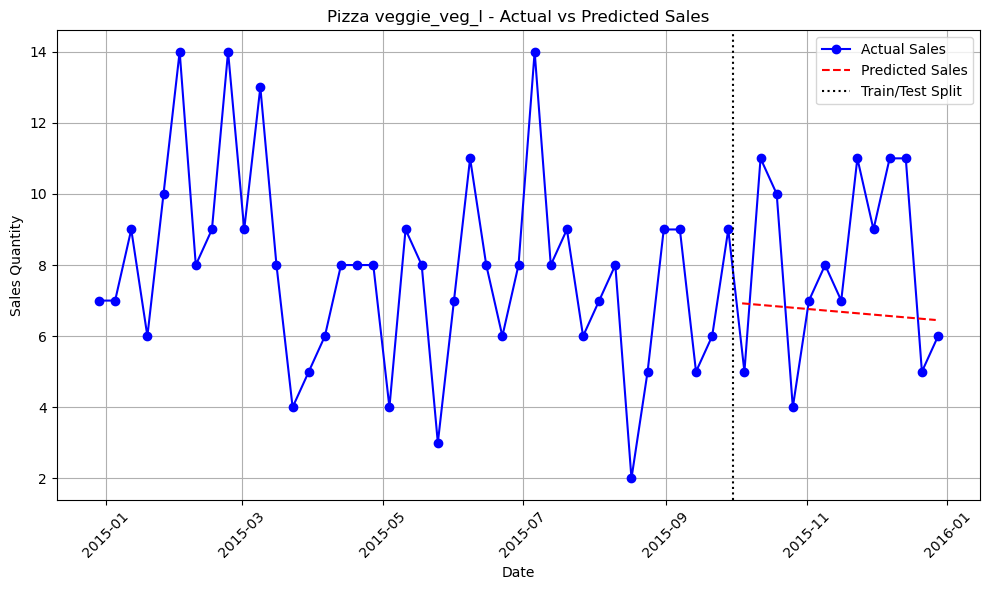

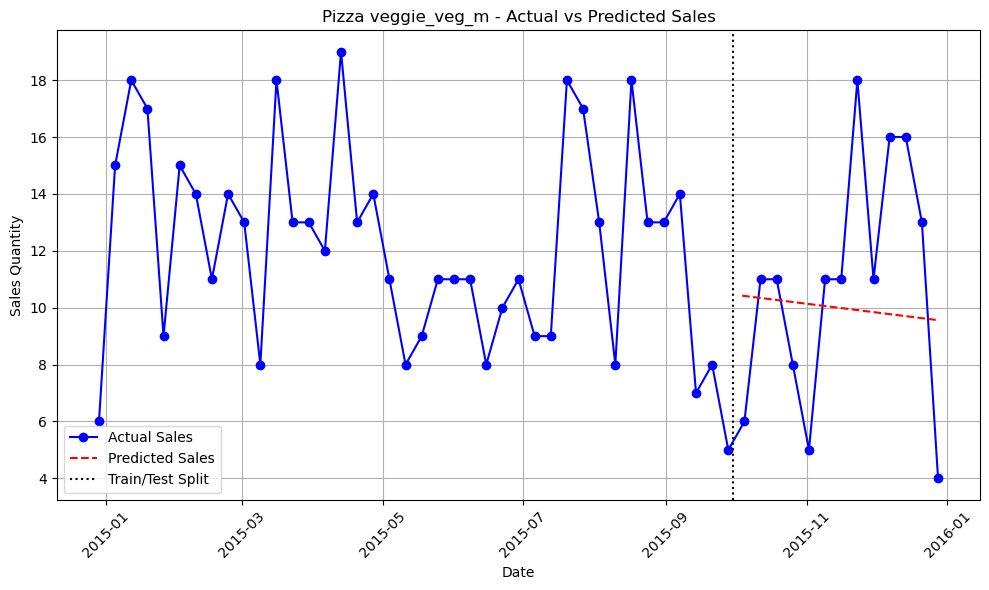

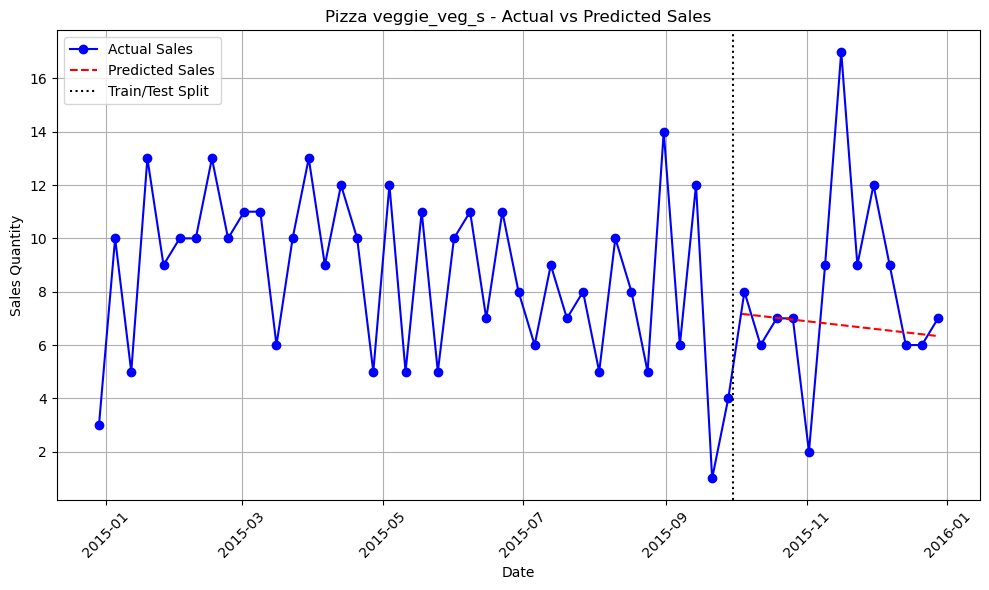

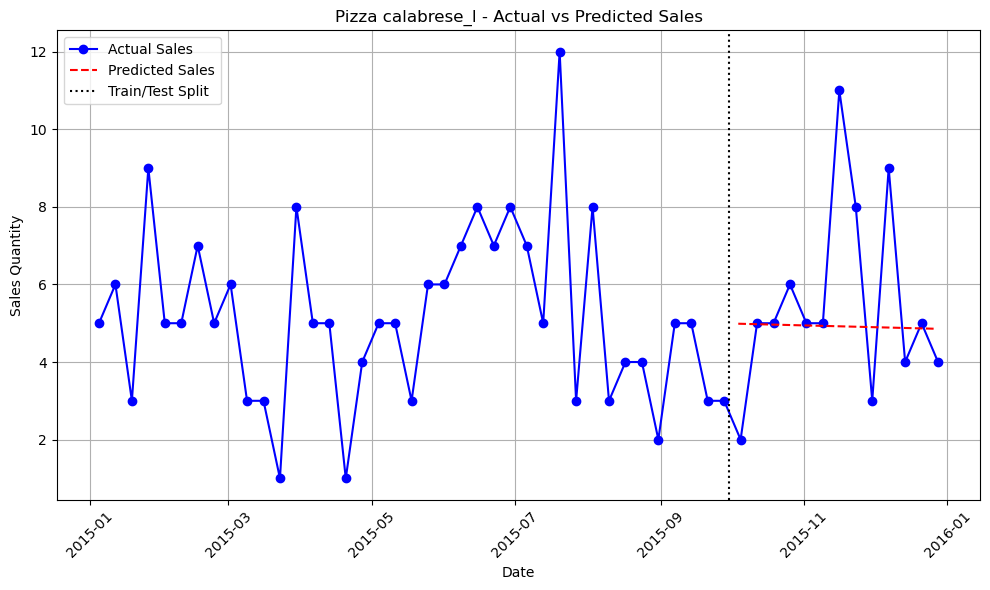

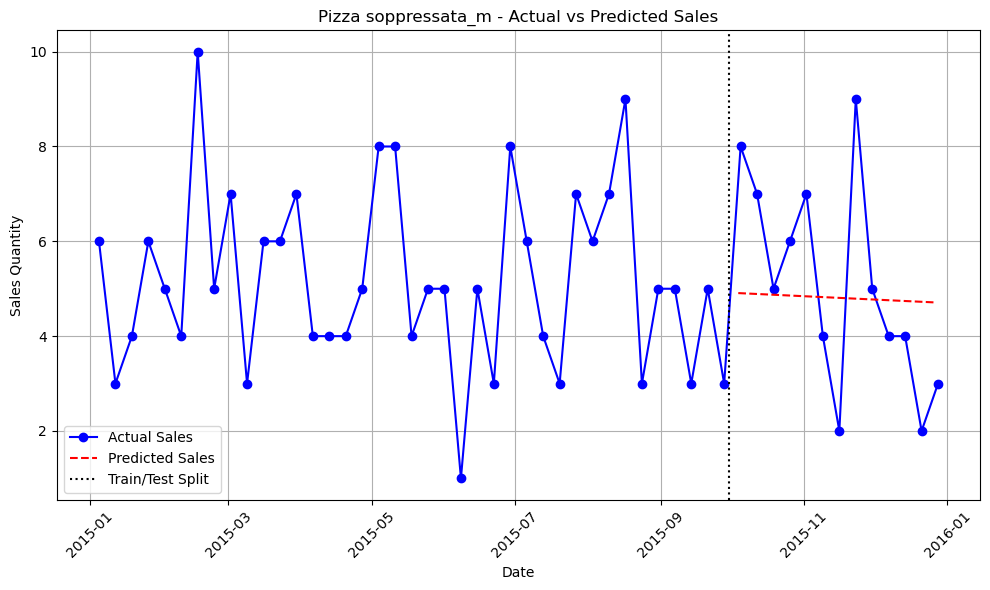

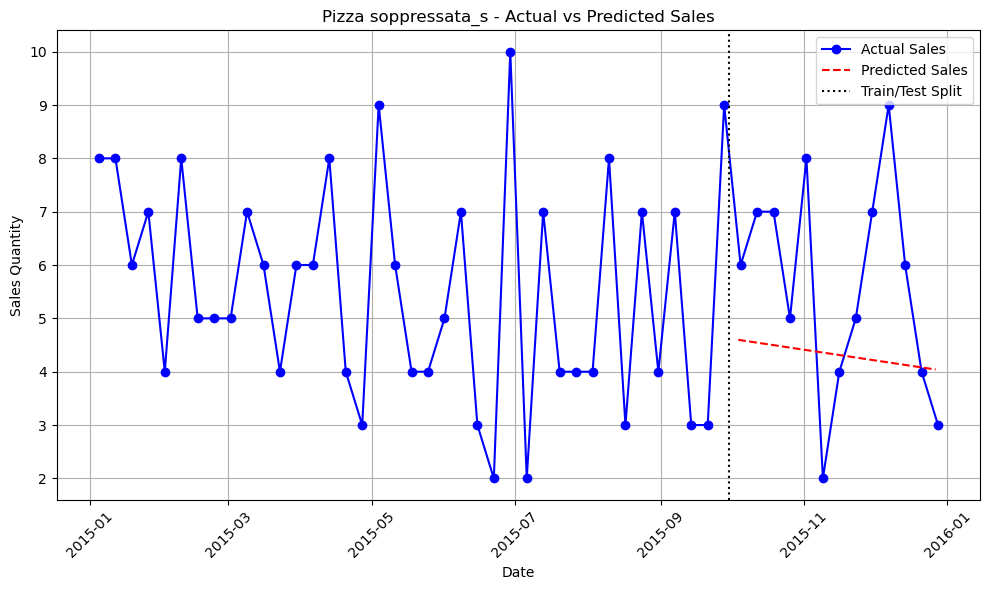

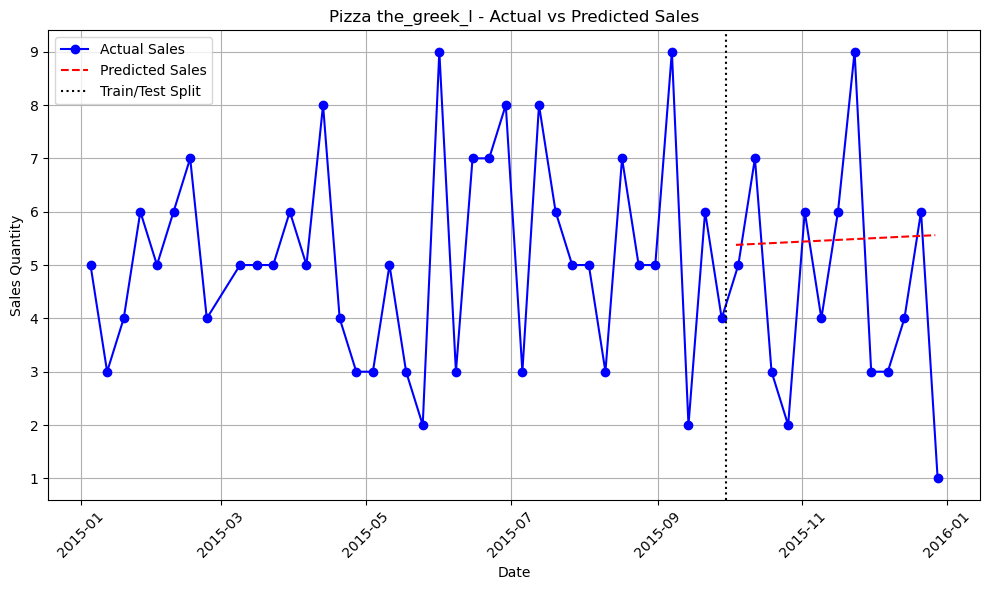

In [37]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error as mape
import matplotlib.pyplot as plt
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Load the data
pizza_sales = pd.read_csv("D:\\Project\\Dominos\\pizza_sales_new.csv")

# Data Preparation - Aggregate pizza sales by week and pizza type
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    df['week'] = df['order_date'].dt.to_period('W').apply(lambda r: r.start_time)
    weekly_sales = df.groupby(['week', 'pizza_name_id'])['quantity'].sum().reset_index()
    weekly_sales.rename(columns={'week': 'ds', 'quantity': 'y'}, inplace=True)  # Required format for Prophet
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(pizza_sales)

# Define holidays and promotional periods
holidays= ['2015-01-01', '2015-01-19', '2015-07-03', '2015-07-04', '2015-09-07']
promotional_periods = ['2015-01-02', '2015-01-03', '2015-01-06', '2015-01-08', '2015-01-10', 
                       '2015-01-14', '2015-01-16', '2015-01-20', '2015-01-22', '2015-01-23', 
                       '2015-01-24', '2015-01-27', '2015-01-30', '2015-01-31', '2015-02-01', 
                       # Shortened for brevity
                       '2015-09-16', '2015-09-17', '2015-09-18', '2015-09-19', '2015-09-26']

# Create holiday DataFrame for Prophet
holiday_df = pd.DataFrame({
    'holiday': 'holiday',  # Label for the event
    'ds': pd.to_datetime(holidays),  # Dates of the holidays
    'lower_window': 0,  # Number of days before the event
    'upper_window': 1  # Number of days after the event
})

# Add promotional periods to the holiday DataFrame
promo_df = pd.DataFrame({
    'holiday': 'promotion',
    'ds': pd.to_datetime(promotional_periods),
    'lower_window': 0,
    'upper_window': 1
})

# Combine holidays and promotional periods
events_df = pd.concat([holiday_df, promo_df])

# Train individual models for each pizza_name_id
def train_models_for_all_pizzas(pizza_sales_weekly, split_date, events_df):
    pizza_models = {}
    pizza_forecasts = {}
    pizza_mape_scores = []

    for pizza_id in pizza_sales_weekly['pizza_name_id'].unique():
        # Filter the sales data for this specific pizza
        pizza_data = pizza_sales_weekly[pizza_sales_weekly['pizza_name_id'] == pizza_id]

        # Split the data into training and testing sets based on the split_date
        train = pizza_data[pizza_data['ds'] <= split_date].copy()
        test = pizza_data[pizza_data['ds'] > split_date].copy()

        # Train Prophet model with holidays and promotional periods
        model = Prophet(holidays=events_df)
        model.fit(train)

        # Make predictions for the test period
        future = model.make_future_dataframe(periods=len(test), freq='W')
        forecast = model.predict(future)

        # Extract predicted values for test period
        predictions = forecast['yhat'][-len(test):].values

        # Calculate MAPE score for model performance
        prophet_mape = mape(test['y'], predictions)
        pizza_mape_scores.append({'pizza_name_id': pizza_id, 'mape': prophet_mape})
        pizza_models[pizza_id] = model  # Save model for later use

        # Save forecasted values
        pizza_forecasts[pizza_id] = forecast[['ds', 'yhat']].tail(len(test)).reset_index(drop=True)

    # Combine all forecasts into a single DataFrame
    all_forecasts = pd.concat([pd.DataFrame({'pizza_name_id': pizza_id, 'ds': pizza_forecasts[pizza_id]['ds'], 'yhat': pizza_forecasts[pizza_id]['yhat']}) 
                                for pizza_id in pizza_forecasts], ignore_index=True)

    return pizza_models, pizza_mape_scores, pizza_forecasts  # Return pizza_forecasts for further use

# Define split_date for training and testing split
split_date = '2015-9-30'  # Define your date for splitting

# Train the models using the date-based split and holidays/promotions
pizza_models, pizza_mape_scores, pizza_forecasts = train_models_for_all_pizzas(pizza_sales_weekly, split_date, events_df)

# Print MAPE for each pizza
for item in pizza_mape_scores:
    print(f'Pizza {item["pizza_name_id"]}: MAPE = {item["mape"]:.2f}')


# Combine actual sales data with forecast results for plotting
def combine_actual_and_forecast(pizza_sales_weekly, pizza_forecasts):
    combined_forecasts = []
    for pizza_id in pizza_forecasts.keys():
        # Actual sales data for pizza_id
        actual_data = pizza_sales_weekly[pizza_sales_weekly['pizza_name_id'] == pizza_id]

        # Forecast data for pizza_id
        forecast_data = pizza_forecasts[pizza_id]

        # Merge actual and forecast data on date ('ds')
        combined_data = pd.merge(actual_data, forecast_data[['ds', 'yhat']], on='ds', how='right')
        combined_data['pizza_name_id'] = pizza_id  # Add pizza_id for each row
        combined_forecasts.append(combined_data)

    return pd.concat(combined_forecasts, ignore_index=True)

# Combine actual and forecast data for plotting
combined_forecasts = combine_actual_and_forecast(pizza_sales_weekly, pizza_forecasts)


# Function to plot actual vs predicted sales
def plot_forecasts(pizza_sales_weekly, combined_forecasts, split_date):
    for pizza_id in combined_forecasts['pizza_name_id'].unique():
        # Get actual and predicted data
        actual_data = pizza_sales_weekly[pizza_sales_weekly['pizza_name_id'] == pizza_id]
        predicted_data = combined_forecasts[combined_forecasts['pizza_name_id'] == pizza_id]

        # Plot actual vs predicted sales
        plt.figure(figsize=(10, 6))
        plt.plot(actual_data['ds'], actual_data['y'], label='Actual Sales', color='blue', marker='o')
        plt.plot(predicted_data['ds'], predicted_data['yhat'], label='Predicted Sales', color='red', linestyle='--')

        # Highlight the train/test split date
        plt.axvline(pd.to_datetime(split_date), color='black', linestyle=':', label='Train/Test Split')

        # Plot details
        plt.title(f'Pizza {pizza_id} - Actual vs Predicted Sales')
        plt.xlabel('Date')
        plt.ylabel('Sales Quantity')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()

        # Show plot
        plt.show()

# Plot forecasts
plot_forecasts(pizza_sales_weekly, combined_forecasts, split_date)


In [39]:
import pandas as pd
from prophet import Prophet
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Load the pizza sales data
pizza_sales = pd.read_csv("D:\\Project\\Dominos\\pizza_sales_new.csv")

# Step 1: Prepare weekly sales by pizza type
def prepare_weekly_sales_by_pizza(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    df['week'] = df['order_date'].dt.to_period('W').apply(lambda r: r.start_time)
    weekly_sales_by_pizza = df.groupby(['week', 'pizza_name_id'])['quantity'].sum().reset_index()
    weekly_sales_by_pizza.rename(columns={'week': 'ds', 'quantity': 'y'}, inplace=True)
    return weekly_sales_by_pizza

pizza_sales_weekly_by_pizza = prepare_weekly_sales_by_pizza(pizza_sales)

# Step 2: Train Prophet models for each pizza type
def train_pizza_models(pizza_sales_weekly_by_pizza):
    pizza_models = {}

    for pizza_id in pizza_sales_weekly_by_pizza['pizza_name_id'].unique():
        pizza_data = pizza_sales_weekly_by_pizza[pizza_sales_weekly_by_pizza['pizza_name_id'] == pizza_id]

        # Train a Prophet model for each pizza type
        model = Prophet()
        model.fit(pizza_data)

        pizza_models[pizza_id] = model  # Save the trained model
    
    return pizza_models

# Train models for all pizza types
pizza_models = train_pizza_models(pizza_sales_weekly_by_pizza)

# Step 3: Predict next week's sales for each pizza type
def forecast_next_week_sales(pizza_models, pizza_sales_weekly_by_pizza, periods=7):
    pizza_forecasts = {}

    for pizza_id in pizza_sales_weekly_by_pizza['pizza_name_id'].unique():
        pizza_data = pizza_sales_weekly_by_pizza[pizza_sales_weekly_by_pizza['pizza_name_id'] == pizza_id]
        model = pizza_models[pizza_id]

        future = model.make_future_dataframe(periods=periods, freq='D')
        forecast = model.predict(future)
        
        # Sum up the forecast for the next week
        forecasted_quantity = forecast[['ds', 'yhat']].tail(periods)['yhat'].sum()
        pizza_forecasts[pizza_id] = forecasted_quantity
    
    return pizza_forecasts

# Step 4: Calculate the ingredient purchase order
def calculate_purchase_order(pizza_forecasts):
    # Load the ingredient data
    ingredients = pd.read_csv("D:\Project\Dominos\pizza_ingredients_cleaned.csv")
    
    # Copy ingredients and map predicted sales
    ingredients['predicted_quantity'] = ingredients['pizza_name_id'].map(pizza_forecasts)
    
    # Calculate total ingredient quantity needed
    ingredients['total_ingredient_qty'] = ingredients['Items_Qty_In_Grams'] * ingredients['predicted_quantity']
    
    # Group by ingredient type and sum the total quantity
    ingredient_totals = ingredients.groupby('pizza_ingredients')['total_ingredient_qty'].sum().reset_index()
    ingredient_totals['total_ingredient_qty_kg'] = ingredient_totals['total_ingredient_qty'] / 1000  # Convert to kg
    
    return ingredient_totals

# Step 5: Generate the forecasts and purchase order
next_week_pizza_sales_forecasts = forecast_next_week_sales(pizza_models, pizza_sales_weekly_by_pizza, periods=7)
purchase_order = calculate_purchase_order(next_week_pizza_sales_forecasts)

# Step 6: Save the purchase order to CSV
purchase_order_output_path = "D:\Project\Dominos\Purchase_Order.csv"
purchase_order.to_csv(purchase_order_output_path, index=False)

# Print the purchase order
print(purchase_order)


20:37:23 - cmdstanpy - INFO - Chain [1] start processing
20:37:24 - cmdstanpy - INFO - Chain [1] done processing
20:37:24 - cmdstanpy - INFO - Chain [1] start processing
20:37:24 - cmdstanpy - INFO - Chain [1] done processing
20:37:24 - cmdstanpy - INFO - Chain [1] start processing
20:37:24 - cmdstanpy - INFO - Chain [1] done processing
20:37:24 - cmdstanpy - INFO - Chain [1] start processing
20:37:24 - cmdstanpy - INFO - Chain [1] done processing
20:37:25 - cmdstanpy - INFO - Chain [1] start processing
20:37:25 - cmdstanpy - INFO - Chain [1] done processing
20:37:25 - cmdstanpy - INFO - Chain [1] start processing
20:37:25 - cmdstanpy - INFO - Chain [1] done processing
20:37:25 - cmdstanpy - INFO - Chain [1] start processing
20:37:25 - cmdstanpy - INFO - Chain [1] done processing
20:37:25 - cmdstanpy - INFO - Chain [1] start processing
20:37:25 - cmdstanpy - INFO - Chain [1] done processing
20:37:26 - cmdstanpy - INFO - Chain [1] start processing
20:37:26 - cmdstanpy - INFO - Chain [1]

          pizza_ingredients  total_ingredient_qty  total_ingredient_qty_kg
0             Alfredo Sauce           2003.115215                 2.003115
1                 Anchovies           5229.327636                 5.229328
2                Artichokes          15491.571561                15.491572
3                   Arugula           1800.554658                 1.800555
4             Asiago Cheese           8842.460212                 8.842460
..                      ...                   ...                      ...
59  Thai Sweet Chilli Sauce           7175.408166                 7.175408
60                    Thyme            302.454424                 0.302454
61                 Tomatoes          72108.157520                72.108158
62                 Zucchini           5628.497657                 5.628498
63             nduja Salami           5364.822689                 5.364823

[64 rows x 3 columns]


In [41]:
df = pd.read_csv("D:\Project\Dominos\Purchase_Order.csv")
df.info()

# Set display option to show all rows
pd.set_option("display.max_rows", None)

# Display the DataFrame
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   pizza_ingredients        64 non-null     object 
 1   total_ingredient_qty     64 non-null     float64
 2   total_ingredient_qty_kg  64 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.6+ KB


pizza_ingredients  total_ingredient_qty  total_ingredient_qty_kg
0                Alfredo Sauce           2003.115215                 2.003115
1                    Anchovies           5229.327636                 5.229328
2                   Artichokes          15491.571561                15.491572
3                      Arugula           1800.554658                 1.800555
4                Asiago Cheese           8842.460212                 8.842460
5                        Bacon          60776.457689                60.776458
6             Barbecue Chicken           8753.486811                 8.753487
7               Barbecue Sauce           3008.604924                 3.008605
8             Beef Chuck Roast          16872.947424                16.872947
9                  Blue Cheese           4408.565739                 4.408566
10           Brie Carre Cheese           1814.726545                 1.814727
11            Calabrese Salami          25960.309315                25.960309
12                   Capocollo          93576.846747                93.576847
13          Caramelized Onions           1209.817696                 1.209818
14                     Chicken         121089.629874               121.089630
15              Chipotle Sauce          10247.933091                10.247933
16             Chorizo Sausage          10831.222245                10.831222
17                    Cilantro           5123.966545                 5.123967
18      Coarse Sicilian Salami          18838.697267                18.838697
19                        Corn          34368.668221                34.368668
20                    Eggplant           4193.498866                 4.193499
21                 Feta Cheese          15170.268146                15.170268
22              Fontina Cheese           8590.729594                 8.590730
23         Friggitello Peppers           1341.205672                 1.341206
24                      Garlic          37441.874496                37.441874
25                Genoa Salami          12022.955176                12.022955
26                 Goat Cheese          19031.311523                19.031312
27  Gorgonzola Piccante Cheese           7669.176432                 7.669176
28                Gouda Cheese           6213.961620                 6.213962
29                Green Olives           7674.710420                 7.674710
30               Green Peppers          11223.305022                11.223305
31             Italian Sausage           2166.244449                 2.166244
32            Jalapeno Peppers           8230.947355                 8.230947
33             Kalamata Olives           4642.715003                 4.642715
34            Luganega Sausage           9419.348633                 9.419349
35           Mozzarella Cheese          25702.966625                25.702967
36                   Mushrooms          46210.571604                46.210572
37                      Onions           4709.674317                 4.709674
38                     Oregano           1983.244769                 1.983245
39                    Pancetta           8047.234033                 8.047234
40  Parmigiano Reggiano Cheese          18262.071983                18.262072
41                       Pears            604.908848                 0.604909
42           Peperoncini verdi           2774.583112                 2.774583
43                   Pepperoni          52446.180493                52.446180
44                 Pesto Sauce           6917.130349                 6.917130
45                   Pineapple          19735.344197                19.735344
46               Plum Tomatoes           5243.683671                 5.243684
47                  Prosciutto           1814.726545                 1.814727
48   Prosciutto di San Daniele           4139.815012                 4.139815
49            Provolone Cheese           4408.565739                 4.408566
50                  Red Onions     